# Workflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# AFEW Loading

In [2]:
import zipfile
import os

# Percorso della cartella dove sono memorizzati i file zip nel tuo Google Drive
zip_folder_path = '/content/drive/MyDrive/AFEW'

# Percorso dove vuoi estrarre i file
extraction_path = '/content/dataset/'

for i in range(1, 13):
    zip_file_path = os.path.join(zip_folder_path, f"{str(i).zfill(2)}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)


# Face Extraction e Frame Resizing

In [3]:
import cv2

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti in RGB
    image = image / 255.0  # Normalizza i valori dei pixel
    image = image.astype(np.float32)
    return image

def crop_face(image, landmarks, expansion_factor=0.2):
    x_coordinates = [int(landmark[0]) for landmark in landmarks]
    y_coordinates = [int(landmark[1]) for landmark in landmarks]

    x_min, x_max = min(x_coordinates), max(x_coordinates)
    y_min, y_max = min(y_coordinates), max(y_coordinates)

    # Calcolo dell'intervallo
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Aggiustamento per l'expansion factor
    x_min = max(x_min - int(x_range * expansion_factor), 0)
    x_max = min(x_max + int(x_range * expansion_factor), image.shape[1])
    y_min = max(y_min - int(y_range * expansion_factor), 0)
    y_max = min(y_max + int(y_range * expansion_factor), image.shape[0])

    # Verifica che le coordinate di ritaglio siano valide
    if x_min >= x_max or y_min >= y_max:
        print(f"Errore di calcolo del ritaglio: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")
        return None

    cropped_face = image[y_min:y_max, x_min:x_max]
    return cropped_face


In [4]:
import os
import numpy as np
import json

def process_video_folder(folder_path, folder_name, save_path):
    images, labels = [], []

    json_path = os.path.join(folder_path, f'{folder_name}.json')
    with open(json_path, 'r') as file:
        json_data = json.load(file)

    for frame_id, frame_info in json_data['frames'].items():
        image_path = os.path.join(folder_path, f"{frame_id}.png")

        image = load_and_preprocess_image(image_path)

        landmarks = frame_info['landmarks']
        cropped_face = crop_face(image, landmarks)
        cropped_face = (cropped_face * 255).astype(np.uint8)
        #resize img to 224,224
        # Salvataggio dell'immagine ritagliata
        resized_cropped_face = cv2.resize(cropped_face, (224,224))  # Ridimensiona l'immagine
        save_folder = os.path.join(save_path, folder_name)
        os.makedirs(save_folder, exist_ok=True)  # Crea la cartella se non esiste
        save_image_path = os.path.join(save_folder, f"{frame_id}.png")
        cv2.imwrite(save_image_path, cv2.cvtColor(resized_cropped_face, cv2.COLOR_RGB2BGR))

        images.append(resized_cropped_face)
        labels.append((frame_info['valence'], frame_info['arousal']))

    return images, labels

In [5]:
import gc
# Pulizia della memoria
gc.collect()

0

In [6]:
import sys

# Percorso dove salverai i dati ridimensionati
save_path = 'dataset_resized'

# Percorso dove hai estratto i dati
extraction_path = 'dataset'

processed_folders = 0
total_folders = len(os.listdir(extraction_path))

X, Y = [], []

for folder_name in os.listdir(extraction_path):
    folder_path = os.path.join(extraction_path, folder_name)
    if os.path.isdir(folder_path):
        images, labels = process_video_folder(folder_path, folder_name, save_path)
        X.extend(images)
        Y.extend(labels)
        processed_folders += 1
        sys.stdout.write(f"\rCartelle processate: {processed_folders}/{total_folders}")
        sys.stdout.flush()

print("\nElaborazione completata.")

gc.collect()

Cartelle processate: 600/601
Elaborazione completata.


0

# Compute Action Unit and Key Frames Extraction

In [33]:
!pip install -q py-feat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.4/381.4 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 74.2 MB/s eta 0:00:00


In [34]:
from feat import Detector

detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
    device='auto'
)

detector

100%|██████████| 176/176 [00:00<00:00, 164592.53it/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.3MB/s]


feat.detector.Detector(face_model=retinaface, landmark_model=mobilefacenet, au_model=xgb, emotion_model=resmasknet, facepose_model=img2pose)

In [ ]:
import os

# Percorso della cartella principale
root_folder = '/content/dataset_resized/'

# Inizializza il conteggio dei frame come None per il confronto
min_frames = None

# Elenco di tutte le sottocartelle
subfolders = [f.path for f in os.scandir(root_folder) if f.is_dir()]

# Calcola il numero minimo di frame in tutte le sottocartelle
for subfolder in subfolders:
    # Lista dei file di frame nella sottocartella
    frame_files = [f for f in os.listdir(subfolder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    num_frames = len(frame_files)

    # Aggiorna il conteggio minimo se necessario
    if min_frames is None or num_frames < min_frames:
        min_frames = num_frames

min_frames


10

In [ ]:
import os

def count_total_frames(folder_path):
    """
    Conta il numero totale di frames nelle sottocartelle di un dato percorso.

    :param folder_path: Percorso della cartella principale contenente le sottocartelle.
    :return: Numero totale di frames.
    """
    total_frames = 0

    # Itera sulle sottocartelle
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            # Conta i file (frame) nella sottocartella
            frames = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
            total_frames += len(frames)

    return total_frames

# Esempio di utilizzo della funzione
folder_path = '/content/dataset/'  # Modifica con il tuo percorso
total_frames = count_total_frames(folder_path)
total_frames



30051

In [ ]:
import numpy as np
import os
import json
from feat import Detector

detector = Detector(au_model='xgb')

def select_key_frames(subfolder_path, max_images, json_data):
    """
    Seleziona i key-frames per variazione delle AU,
    mantenendo l'ordine cronologico dei frame.
    """
    frame_ids = sorted(os.listdir(subfolder_path))  # Ordina i frame per nome
    au_variations = []
    frame_data = []

    for filename in frame_ids:
        if filename.endswith((".jpg", ".png", ".jpeg")):
            frame_id = filename.split('.')[0]
            image_path = os.path.join(subfolder_path, filename)

            try:
                # Ottieni i valori di arousal e valence per l'immagine corrente
                arousal = json_data['frames'][frame_id]['arousal']
                valence = json_data['frames'][frame_id]['valence']

                # Esegui la detection delle AU
                prediction = detector.detect_image(image_path)
                au_values = np.array(list(prediction.aus.iloc[0]))
                au_variations.append(np.std(au_values))  # Variazione come deviazione standard

                frame_data.append((image_path, arousal, valence))
            except Exception as e:
                print(f"Errore durante l'elaborazione di {image_path}: {e}")

    # Seleziona gli indici dei frame con le maggiori variazioni
    sorted_indices = np.argsort(au_variations)
    key_frame_indices = sorted_indices[-max_images:] if max_images <= len(sorted_indices) else sorted_indices
    key_frames_ordered = sorted(key_frame_indices)  # Mantiene l'ordine cronologico

    return [frame_data[i] for i in key_frames_ordered]



In [ ]:
import pandas as pd

def process_images_with_key_frame_extraction(folder_path, max_folders=600, max_images_per_folder=10, start_folder_index=0):
    """
    Processa le immagini in un dato percorso per estrarre le Action Units (AU)
    e i valori di arousal e valence, a partire da una specifica cartella.

    :param folder_path: Percorso della cartella contenente le immagini.
    :param max_folders: Numero massimo di sotto-cartelle da processare.
    :param max_images_per_folder: Numero massimo di immagini da processare per sotto-cartella.
    :param start_folder_index: Indice della cartella da cui iniziare l'elaborazione.
    :return: DataFrame con i valori delle AU, arousal e valence per ogni immagine processata.
    """
    aus_results = []

    print(f"Elaborazione della cartella: {folder_path}")
    sorted_folders = sorted(os.listdir(folder_path))
    for i, folder_name in enumerate(sorted_folders):
        if i < start_folder_index:
            continue
        if i >= start_folder_index + max_folders:
            break

        subfolder_path = os.path.join(folder_path, folder_name)
        json_path = os.path.join('/content/dataset/'+folder_name+'/', f'{folder_name}.json')

        print(f"Elaborazione della sotto-cartella: {subfolder_path}")
        if not os.path.isdir(subfolder_path) or not os.path.exists(json_path):
            print(f"Cartella o file JSON non trovati: {subfolder_path}, {json_path}")
            continue

        with open(json_path, 'r') as file:
            json_data = json.load(file)

        key_frames = select_key_frames(subfolder_path, max_images_per_folder, json_data)

        for image_path, arousal, valence in key_frames:
            try:
                # Esegui la detection delle AU
                prediction = detector.detect_image(image_path)
                au_values = prediction.aus.iloc[0].to_dict()

                # Aggiungi image_path all'inizio del dizionario
                au_values = {'image_path': image_path, **au_values}

                au_values.update({'arousal': arousal, 'valence': valence})
                aus_results.append(au_values)
            except Exception as e:
                print(f"Errore durante l'elaborazione di {image_path}: {e}")

    return pd.DataFrame(aus_results)

In [ ]:
# Percorso della cartella principale del dataset
dataset_path = "/content/dataset_resized/"

# Processa le immagini nel dataset
# Puoi modificare 'max_folders' in base al numero di sotto-cartelle che vuoi processare
aus_data = process_images_with_key_frame_extraction(dataset_path,200,start_folder_index=0)

# Stampa i primi record per avere un'anteprima dei dati
print(aus_data.head())

# Ora 'aus_data' è un DataFrame che puoi utilizzare per ulteriori analisi o per addestrare un modello


In [ ]:
aus_data.shape

(2000, 23)

In [ ]:
aus_data_cleaned = aus_data.dropna()

# Verifica le dimensioni del DataFrame dopo la pulizia
print(aus_data_cleaned.shape)

(2000, 23)


In [ ]:
aus_data.head()

,image_path,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,...,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43,arousal,valence
0,/content/dataset_resized/001/00000.png,0.441251,0.343375,0.440618,0.351839,0.209998,0.0,0.230523,0.001349,0.0,...,0.430306,1.0,0.272994,0.341583,0.955296,0.763431,0.071433,0.135054,5.0,0.0
1,/content/dataset_resized/001/00001.png,0.421926,0.363765,0.434397,0.351787,0.203124,0.0,0.224019,0.008139,0.0,...,0.433068,1.0,0.267938,0.344917,0.986915,0.800393,0.100110,0.152723,5.0,0.0
2,/content/dataset_resized/001/00007.png,0.492545,0.382224,0.621281,0.444887,0.186932,0.0,0.223182,0.000403,0.0,...,0.482991,1.0,0.181584,0.279610,0.928026,0.693113,0.099127,0.141085,5.0,0.0
3,/content/dataset_resized/001/00024.png,0.391621,0.282561,0.718449,0.403961,0.195292,0.0,0.253391,0.033507,1.0,...,0.424992,1.0,0.480082,0.409115,0.932144,0.593253,0.088416,0.163365,5.0,0.0
4,/content/dataset_resized/001/00026.png,0.376173,0.305542,0.397151,0.406158,0.196051,1.0,0.300231,0.001653,0.0,...,0.424217,1.0,0.324522,0.376909,0.952130,0.631469,0.109218,0.128785,5.0,0.0


In [ ]:
# Calcoliamo la media dei valori di arousal e valence
media_arousal = aus_data['arousal'].mean()
media_valence = aus_data['valence'].mean()

media_arousal, media_valence

(2.94, -0.4625)

In [ ]:
len(aus_data)

6000

In [ ]:
aus_data.to_csv('afew_keyframes.csv', index=False)

# Linear Combination of Landmarks

In [7]:
import pandas as pd
# Percorso del file CSV
file_path = 'data/afew_keyframes.csv'

# Carica il DataFrame dal file CSV
aus_data = pd.read_csv(file_path)

aus_data.head()

,image_path,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,...,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43,arousal,valence
0,/content/dataset_resized/401/00015.png,0.311357,0.135927,0.798931,0.328358,0.113616,1.0,0.493366,0.029253,0.0,...,0.257176,1.0,0.719543,0.268569,0.993881,0.885669,0.501640,0.786895,1.0,-1.0
1,/content/dataset_resized/401/00016.png,0.291428,0.148411,0.881824,0.365231,0.104657,1.0,0.360925,0.062726,0.0,...,0.327704,1.0,0.655670,0.382354,0.990813,0.953209,0.437312,0.711133,1.0,-1.0
2,/content/dataset_resized/401/00018.png,0.340948,0.113658,0.831665,0.340745,0.084021,0.0,0.353916,0.018393,0.0,...,0.309095,1.0,0.407399,0.346851,0.978948,0.869907,0.266384,0.741665,1.0,-1.0
3,/content/dataset_resized/401/00031.png,0.291201,0.127205,0.756636,0.326717,0.118116,0.0,0.433923,0.005935,0.0,...,0.297202,1.0,0.264385,0.346684,0.999072,0.740485,0.712587,0.701903,2.0,-1.0
4,/content/dataset_resized/401/00046.png,0.360045,0.199449,0.859479,0.252883,0.122171,1.0,0.447879,0.063832,0.0,...,0.340059,1.0,0.582021,0.231151,0.994853,0.659481,0.780542,0.535933,2.0,-1.0


In [8]:
import pandas as pd
import os
import json
import numpy as np

columns_names = [f'Landmark_x_{i}' for i in range(68)]
columns_names1 = [f'Landmark_y_{i}' for i in range(68)]

all_columns_names = columns_names + columns_names1

df = pd.DataFrame(columns=all_columns_names)

for index, row in aus_data.iterrows():

  directory_path, file_name = os.path.split(row['image_path'])
  directory_path = directory_path.replace('_resized', '')
  json_name = directory_path.split('/')[3]
  file_name = file_name.split('.')[0]

  json_path = f'{directory_path}/{json_name}.json'
  with open(json_path, 'r') as file:
      json_data = json.load(file)

  landmarks = json_data['frames'][file_name]['landmarks']
  #print(f"Frame ID: {frame_id}")

  vec_comb_lin_x = []
  vec_comb_lin_y = []

  land_x = np.array([int(x) for x, _ in landmarks])
  land_y = np.array([int(y) for _, y in landmarks])
      #print(f"Landmark {idx + 1}: ({x}, {y})")

  for i in range(68):
    sum_x = 0
    sum_y = 0

    for j in range(68):
      sum_x = sum_x + land_x[i] * (1/land_x[j])
      sum_y = sum_y + land_y[i] * (1/land_y[j])

    vec_comb_lin_x.append(sum_x)
    vec_comb_lin_y.append(sum_y)

  all_landmark = vec_comb_lin_x + vec_comb_lin_y

  new_df = pd.DataFrame([all_landmark], columns=df.columns)

  # Concatenate the original DataFrame and the new DataFrame
  df = pd.concat([df, new_df], ignore_index=True)

  #return pd.DataFrame(aus_results)

<ipython-input-8-0faa7dc697b8>:39: RuntimeWarning: divide by zero encountered in long_scalars
  sum_x = sum_x + land_x[i] * (1/land_x[j])
<ipython-input-8-0faa7dc697b8>:39: RuntimeWarning: invalid value encountered in double_scalars
  sum_x = sum_x + land_x[i] * (1/land_x[j])


In [9]:
df

,Landmark_x_0,Landmark_x_1,Landmark_x_2,Landmark_x_3,Landmark_x_4,Landmark_x_5,Landmark_x_6,Landmark_x_7,Landmark_x_8,Landmark_x_9,...,Landmark_y_58,Landmark_y_59,Landmark_y_60,Landmark_y_61,Landmark_y_62,Landmark_y_63,Landmark_y_64,Landmark_y_65,Landmark_y_66,Landmark_y_67
0,50.012623,50.229128,51.311652,53.043691,55.858254,59.322332,62.786410,66.683498,70.580585,73.611653,...,88.867585,87.158593,82.886113,80.322625,80.037793,79.752961,81.177121,85.164769,85.734433,85.734433
1,50.213808,50.430246,51.512440,53.243951,56.057656,59.520677,63.200137,67.096036,70.991935,73.805640,...,88.436996,87.015179,82.749730,80.474823,80.190460,79.906096,81.043550,84.740273,85.593363,85.593363
2,50.123587,50.340572,51.425498,52.944394,55.765202,58.802995,62.491744,66.397478,70.303212,73.341005,...,88.126393,86.700399,82.707618,80.996426,80.711227,80.426028,81.281624,84.418810,85.274406,85.274406
3,49.159634,49.612718,50.518886,52.557765,55.729354,59.354028,63.205243,67.509543,71.587301,74.758890,...,88.725191,87.013451,82.734101,80.166491,80.166491,79.595911,80.737071,84.731131,85.587001,85.587001
4,48.385258,48.621284,49.565386,51.217566,54.285899,57.826284,62.074746,66.559233,71.279746,75.056156,...,87.698894,86.544962,83.083163,81.063781,81.063781,80.486814,81.352264,83.948613,84.525579,84.525579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,57.384650,57.384650,58.197464,59.660528,61.286156,63.074346,65.025099,67.788666,71.527609,75.266552,...,92.540042,90.953641,86.987640,84.608038,84.343638,83.814838,84.079238,88.309640,89.102840,89.102840
5996,57.507875,57.507875,58.317845,59.775792,61.557726,63.177666,65.121594,67.713498,71.277367,75.165223,...,91.264913,90.215891,86.806569,84.970781,84.708525,84.184014,83.921759,87.331080,88.117847,88.117847
5997,56.870898,56.870898,57.647823,59.201673,61.066292,63.241682,65.261686,67.747846,71.010930,74.429400,...,91.284954,89.711076,86.825632,86.038693,86.038693,85.514066,84.989440,87.350258,87.874884,87.874884
5998,56.737361,56.586464,57.190053,58.548128,60.509792,62.622353,64.584018,66.998373,69.865421,72.883366,...,94.327038,92.114087,87.688185,85.751853,85.751853,85.475234,86.028472,90.454374,91.007612,90.730993


In [81]:
merged_df = pd.merge(df, aus_data, left_index=True, right_index=True, how='inner')

In [82]:
merged_df

,Landmark_x_0,Landmark_x_1,Landmark_x_2,Landmark_x_3,Landmark_x_4,Landmark_x_5,Landmark_x_6,Landmark_x_7,Landmark_x_8,Landmark_x_9,...,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43,arousal,valence
0,50.012623,50.229128,51.311652,53.043691,55.858254,59.322332,62.786410,66.683498,70.580585,73.611653,...,0.257176,1.0,0.719543,0.268569,0.993881,0.885669,0.501640,0.786895,1.0,-1.0
1,50.213808,50.430246,51.512440,53.243951,56.057656,59.520677,63.200137,67.096036,70.991935,73.805640,...,0.327704,1.0,0.655670,0.382354,0.990813,0.953209,0.437312,0.711133,1.0,-1.0
2,50.123587,50.340572,51.425498,52.944394,55.765202,58.802995,62.491744,66.397478,70.303212,73.341005,...,0.309095,1.0,0.407399,0.346851,0.978948,0.869907,0.266384,0.741665,1.0,-1.0
3,49.159634,49.612718,50.518886,52.557765,55.729354,59.354028,63.205243,67.509543,71.587301,74.758890,...,0.297202,1.0,0.264385,0.346684,0.999072,0.740485,0.712587,0.701903,2.0,-1.0
4,48.385258,48.621284,49.565386,51.217566,54.285899,57.826284,62.074746,66.559233,71.279746,75.056156,...,0.340059,1.0,0.582021,0.231151,0.994853,0.659481,0.780542,0.535933,2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,57.384650,57.384650,58.197464,59.660528,61.286156,63.074346,65.025099,67.788666,71.527609,75.266552,...,0.539658,0.0,0.722313,0.064561,0.998532,0.746642,0.063520,0.549602,3.0,-1.0
5996,57.507875,57.507875,58.317845,59.775792,61.557726,63.177666,65.121594,67.713498,71.277367,75.165223,...,0.545938,0.0,0.603435,0.156507,0.986948,0.566380,0.103323,0.467108,3.0,-1.0
5997,56.870898,56.870898,57.647823,59.201673,61.066292,63.241682,65.261686,67.747846,71.010930,74.429400,...,0.508652,0.0,0.459939,0.352326,0.965488,0.837143,0.633322,0.098899,2.0,0.0
5998,56.737361,56.586464,57.190053,58.548128,60.509792,62.622353,64.584018,66.998373,69.865421,72.883366,...,0.545037,0.0,0.535025,0.066318,0.992853,0.892109,0.421667,0.059766,2.0,0.0


In [83]:
merged_df = merged_df.dropna()

In [13]:
merged_df = merged_df.drop(['image_path', 'arousal', 'valence'], axis=1)

In [ ]:
merged_df

,Landmark_x_0,Landmark_x_1,Landmark_x_2,Landmark_x_3,Landmark_x_4,Landmark_x_5,Landmark_x_6,Landmark_x_7,Landmark_x_8,Landmark_x_9,...,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
0,50.012623,50.229128,51.311652,53.043691,55.858254,59.322332,62.786410,66.683498,70.580585,73.611653,...,0.194991,0.467736,0.257176,1.0,0.719543,0.268569,0.993881,0.885669,0.501640,0.786895
1,50.213808,50.430246,51.512440,53.243951,56.057656,59.520677,63.200137,67.096036,70.991935,73.805640,...,0.206847,0.223989,0.327704,1.0,0.655670,0.382354,0.990813,0.953209,0.437312,0.711133
2,50.123587,50.340572,51.425498,52.944394,55.765202,58.802995,62.491744,66.397478,70.303212,73.341005,...,0.180410,0.385084,0.309095,1.0,0.407399,0.346851,0.978948,0.869907,0.266384,0.741665
3,49.159634,49.612718,50.518886,52.557765,55.729354,59.354028,63.205243,67.509543,71.587301,74.758890,...,0.203248,0.433349,0.297202,1.0,0.264385,0.346684,0.999072,0.740485,0.712587,0.701903
4,48.385258,48.621284,49.565386,51.217566,54.285899,57.826284,62.074746,66.559233,71.279746,75.056156,...,0.355545,0.677510,0.340059,1.0,0.582021,0.231151,0.994853,0.659481,0.780542,0.535933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,57.384650,57.384650,58.197464,59.660528,61.286156,63.074346,65.025099,67.788666,71.527609,75.266552,...,0.291543,0.753380,0.539658,0.0,0.722313,0.064561,0.998532,0.746642,0.063520,0.549602
5996,57.507875,57.507875,58.317845,59.775792,61.557726,63.177666,65.121594,67.713498,71.277367,75.165223,...,0.200482,0.404790,0.545938,0.0,0.603435,0.156507,0.986948,0.566380,0.103323,0.467108
5997,56.870898,56.870898,57.647823,59.201673,61.066292,63.241682,65.261686,67.747846,71.010930,74.429400,...,0.141673,0.341747,0.508652,0.0,0.459939,0.352326,0.965488,0.837143,0.633322,0.098899
5998,56.737361,56.586464,57.190053,58.548128,60.509792,62.622353,64.584018,66.998373,69.865421,72.883366,...,0.119963,0.570278,0.545037,0.0,0.535025,0.066318,0.992853,0.892109,0.421667,0.059766


In [ ]:
merged_df.to_csv('landmarks.csv', index=False)

# Train our detection model

In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

# Nuovi parametri ottimizzati
learning_rate_opt = 8.574491575670956e-05
dropout_rate_opt = 0.23569115438975155
batch_size_opt = 32
epochs_opt = 200

# Creazione del modello con i nuovi parametri
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(136,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_rate_opt))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_rate_opt))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_rate_opt))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_rate_opt))

model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout_rate_opt))

model.add(layers.Dense(20, activation='linear'))

# Creazione del programma di decadimento esponenziale
lr_schedule = ExponentialDecay(learning_rate_opt, decay_steps=10000, decay_rate=0.9, staircase=True)

# Cambio dell'ottimizzatore a RMSprop con i nuovi parametri
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

# Definizione della callback di early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=12,
                               restore_best_weights=True,
                               verbose=1)

# Compilazione del modello con il nuovo ottimizzatore
model.compile(optimizer=optimizer, loss=tf.keras.losses.LogCosh(), metrics=['mae'])

# Stampa della struttura del modello
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_336 (Dense)           (None, 256)               35072     
                                                                 
 batch_normalization_280 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout_280 (Dropout)       (None, 256)               0         
                                                                 
 dense_337 (Dense)           (None, 128)               32896     
                                                                 
 batch_normalization_281 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dropout_281 (Dropout)       (None, 128)             

In [15]:
aus_names_list = merged_df.columns.to_list()[136:]

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = merged_df.drop(aus_names_list, axis=1)
y = merged_df[aus_names_list]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming X_train and X_test are your input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestramento del modello
model.fit(X_train, y_train, epochs=epochs_opt, batch_size=batch_size_opt, validation_split=0.2)

# Dopo l'addestramento, puoi utilizzare il modello per fare predizioni su nuovi dati
# Supponendo che tu abbia dati di test: X_test
predictions = model.predict(X_test)

# Ora 'predictions' conterrà le previsioni del tuo modello per i dati di test

Epoch 1/200
120/120 [==============================] - 5s 13ms/step - loss: 0.4827 - mae: 0.9269 - val_loss: 1.7669 - val_mae: 2.3838
Epoch 2/200
120/120 [==============================] - 1s 9ms/step - loss: 0.4404 - mae: 0.8734 - val_loss: 0.3217 - val_mae: 0.7365
Epoch 3/200
120/120 [==============================] - 1s 8ms/step - loss: 0.4016 - mae: 0.8225 - val_loss: 0.2191 - val_mae: 0.5738
Epoch 4/200
120/120 [==============================] - 1s 8ms/step - loss: 0.3672 - mae: 0.7775 - val_loss: 0.1965 - val_mae: 0.5307
Epoch 5/200
120/120 [==============================] - 1s 5ms/step - loss: 0.3336 - mae: 0.7318 - val_loss: 0.2154 - val_mae: 0.5701
Epoch 6/200
120/120 [==============================] - 1s 5ms/step - loss: 0.3043 - mae: 0.6905 - val_loss: 0.1783 - val_mae: 0.5111
Epoch 7/200
120/120 [==============================] - 1s 5ms/step - loss: 0.2773 - mae: 0.6531 - val_loss: 0.1836 - val_mae: 0.5159
Epoch 8/200
120/120 [==============================] - 1s 5ms/step -

In [66]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")

38/38 [==============================] - 1s 5ms/step - loss: 0.0297 - mae: 0.1824
Mean Squared Error (MSE): 0.02973225899040699
Mean Absolute Error (MAE): 0.18241603672504425


In [ ]:
model.save('au_pred_model.h5')

# Fine Tuning Model

In [19]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

# Funzione obiettivo per Optuna
def objective(trial):
    # Iperparametri da ottimizzare
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    epochs = trial.suggest_categorical('epochs', [50, 100, 150, 200])

    # Creazione del modello
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(136,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_rate', 0.1, 0.9)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_rate', 0.1, 0.9)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_rate', 0.1, 0.9)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_rate', 0.1, 0.9)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_rate', 0.1, 0.9)))
    model.add(layers.Dense(20, activation='linear'))

    lr_schedule = ExponentialDecay(learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.LogCosh(), metrics=['mae'])

    # Addestramento del modello
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    # Valutazione delle prestazioni sul set di validazione
    val_loss = history.history['val_loss'][-1]

    return val_loss

# Creazione dell'oggetto Optuna Study
study = optuna.create_study(direction='minimize')

# Esecuzione dell'ottimizzazione degli iperparametri
study.optimize(objective, n_trials=50)

# Stampa dei risultati migliori
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-01-25 17:59:30,514] A new study created in memory with name: no-name-48322fe4-15ce-4501-ab8f-8204e69d6562
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
30/30 [==============================] - 8s 60ms/step - loss: 0.1909 - mae: 0.4918 - val_loss: 8.4595 - val_mae: 9.1388
Epoch 2/200
30/30 [==============================] - 1s 22ms/step - loss: 0.0701 - mae: 0.2842 - val_loss: 1.8946 - val_mae: 2.4819
Epoch 3/200
30/30 [==============================] - 1s 24ms/step - loss: 0.0497 - mae: 0.2460 - val_loss: 1.0004 - val_mae: 1.5133
Epoch 4/200
30/30 [==============================] - 1s 25ms/step - loss: 0.0432 - mae: 0.2340 - val_loss: 0.1183 - val_mae: 0.4359
Epoch 5/200
30/30 [==============================] - 1s 25ms/step - loss: 0.0402 - mae: 0.2270 - val_loss: 0.0446 - val_mae: 0.2426
Epoch 6/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0386 - mae: 0.2222 - val_loss: 0.0421 - val_mae: 0.2308
Epoch 7/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0373 - mae: 0.2166 - val_loss: 0.0521 - val_mae: 0.2524
Epoch 8/200
30/30 [==============================] - 1s 19ms/step - loss: 0.

[I 2024-01-25 18:02:23,292] Trial 0 finished with value: 0.039827607572078705 and parameters: {'learning_rate': 0.006421476326277428, 'dropout_rate': 0.36888127980912266, 'batch_size': 128, 'epochs': 200}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
60/60 [==============================] - 3s 14ms/step - loss: 1.0536 - mae: 1.5480 - val_loss: 0.1679 - val_mae: 0.4905
Epoch 2/100
60/60 [==============================] - 0s 8ms/step - loss: 1.0305 - mae: 1.5180 - val_loss: 0.1900 - val_mae: 0.5216
Epoch 3/100
60/60 [==============================] - 1s 9ms/step - loss: 1.0088 - mae: 1.4928 - val_loss: 0.1960 - val_mae: 0.5285
Epoch 4/100
60/60 [==============================] - 1s 8ms/step - loss: 0.9874 - mae: 1.4711 - val_loss: 0.1972 - val_mae: 0.5335
Epoch 5/100
60/60 [==============================] - 1s 12ms/step - loss: 0.9409 - mae: 1.4179 - val_loss: 0.1914 - val_mae: 0.5246
Epoch 6/100
60/60 [==============================] - 1s 11ms/step - loss: 0.9450 - mae: 1.4214 - val_loss: 0.1880 - val_mae: 0.5208
Epoch 7/100
60/60 [==============================] - 1s 11ms/step - loss: 0.8973 - mae: 1.3709 - val_loss: 0.1824 - val_mae: 0.5116
Epoch 8/100
60/60 [==============================] - 1s 11ms/step - loss: 0.874

[I 2024-01-25 18:03:29,819] Trial 1 finished with value: 0.04360068589448929 and parameters: {'learning_rate': 8.137552267078367e-05, 'dropout_rate': 0.8392795998396673, 'batch_size': 64, 'epochs': 100}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/50
15/15 [==============================] - 3s 36ms/step - loss: 0.6521 - mae: 1.1050 - val_loss: 5.0864 - val_mae: 5.7619
Epoch 2/50
15/15 [==============================] - 0s 14ms/step - loss: 0.6487 - mae: 1.0996 - val_loss: 2.7166 - val_mae: 3.3539
Epoch 3/50
15/15 [==============================] - 0s 15ms/step - loss: 0.6441 - mae: 1.0969 - val_loss: 1.5692 - val_mae: 2.1688
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.6409 - mae: 1.0920 - val_loss: 0.9388 - val_mae: 1.4880
Epoch 5/50
15/15 [==============================] - 0s 17ms/step - loss: 0.6473 - mae: 1.0998 - val_loss: 0.5466 - val_mae: 1.0434
Epoch 6/50
15/15 [==============================] - 0s 15ms/step - loss: 0.6290 - mae: 1.0785 - val_loss: 0.3146 - val_mae: 0.7457
Epoch 7/50
15/15 [==============================] - 0s 17ms/step - loss: 0.6413 - mae: 1.0932 - val_loss: 0.1957 - val_mae: 0.5596
Epoch 8/50
15/15 [==============================] - 0s 18ms/step - loss: 0.6418 - m

[I 2024-01-25 18:03:47,163] Trial 2 finished with value: 0.22295750677585602 and parameters: {'learning_rate': 6.443621431943101e-06, 'dropout_rate': 0.6527680740221705, 'batch_size': 256, 'epochs': 50}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/150
30/30 [==============================] - 3s 21ms/step - loss: 0.4017 - mae: 0.7898 - val_loss: 5.6953 - val_mae: 6.3287
Epoch 2/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1736 - mae: 0.4616 - val_loss: 1.9964 - val_mae: 2.5768
Epoch 3/150
30/30 [==============================] - 0s 11ms/step - loss: 0.0909 - mae: 0.3243 - val_loss: 0.4317 - val_mae: 0.8381
Epoch 4/150
30/30 [==============================] - 0s 9ms/step - loss: 0.0545 - mae: 0.2605 - val_loss: 0.0754 - val_mae: 0.3023
Epoch 5/150
30/30 [==============================] - 0s 10ms/step - loss: 0.0431 - mae: 0.2362 - val_loss: 0.0469 - val_mae: 0.2247
Epoch 6/150
30/30 [==============================] - 0s 10ms/step - loss: 0.0410 - mae: 0.2316 - val_loss: 0.0442 - val_mae: 0.2327
Epoch 7/150
30/30 [==============================] - 0s 11ms/step - loss: 0.0405 - mae: 0.2303 - val_loss: 0.0399 - val_mae: 0.2293
Epoch 8/150
30/30 [==============================] - 0s 16ms/step - loss: 0.0

[I 2024-01-25 18:05:11,670] Trial 3 finished with value: 0.15562234818935394 and parameters: {'learning_rate': 0.003628031185395325, 'dropout_rate': 0.6295512530779386, 'batch_size': 128, 'epochs': 150}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
60/60 [==============================] - 4s 16ms/step - loss: 0.4366 - mae: 0.8670 - val_loss: 1.8386 - val_mae: 2.4212
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 0.4307 - mae: 0.8586 - val_loss: 0.7065 - val_mae: 1.2005
Epoch 3/100
60/60 [==============================] - 0s 7ms/step - loss: 0.4282 - mae: 0.8548 - val_loss: 0.3837 - val_mae: 0.8128
Epoch 4/100
60/60 [==============================] - 0s 8ms/step - loss: 0.4232 - mae: 0.8484 - val_loss: 0.2204 - val_mae: 0.5846
Epoch 5/100
60/60 [==============================] - 0s 8ms/step - loss: 0.4184 - mae: 0.8438 - val_loss: 0.1921 - val_mae: 0.5405
Epoch 6/100
60/60 [==============================] - 0s 7ms/step - loss: 0.4144 - mae: 0.8376 - val_loss: 0.1993 - val_mae: 0.5514
Epoch 7/100
60/60 [==============================] - 0s 8ms/step - loss: 0.4075 - mae: 0.8276 - val_loss: 0.2022 - val_mae: 0.5526
Epoch 8/100
60/60 [==============================] - 0s 7ms/step - loss: 0.4012 - 

[I 2024-01-25 18:06:36,882] Trial 4 finished with value: 0.11100940406322479 and parameters: {'learning_rate': 1.0992038168078248e-05, 'dropout_rate': 0.16611554221563118, 'batch_size': 64, 'epochs': 100}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
60/60 [==============================] - 3s 12ms/step - loss: 0.7761 - mae: 1.2506 - val_loss: 0.3897 - val_mae: 0.8316
Epoch 2/200
60/60 [==============================] - 0s 7ms/step - loss: 0.7767 - mae: 1.2506 - val_loss: 0.1716 - val_mae: 0.5034
Epoch 3/200
60/60 [==============================] - 0s 7ms/step - loss: 0.7837 - mae: 1.2595 - val_loss: 0.1563 - val_mae: 0.4772
Epoch 4/200
60/60 [==============================] - 0s 7ms/step - loss: 0.7894 - mae: 1.2649 - val_loss: 0.1497 - val_mae: 0.4633
Epoch 5/200
60/60 [==============================] - 0s 8ms/step - loss: 0.7759 - mae: 1.2502 - val_loss: 0.1511 - val_mae: 0.4633
Epoch 6/200
60/60 [==============================] - 0s 8ms/step - loss: 0.7829 - mae: 1.2586 - val_loss: 0.1484 - val_mae: 0.4563
Epoch 7/200
60/60 [==============================] - 0s 7ms/step - loss: 0.7775 - mae: 1.2514 - val_loss: 0.1501 - val_mae: 0.4595
Epoch 8/200
60/60 [==============================] - 0s 8ms/step - loss: 0.7730 - 

[I 2024-01-25 18:09:01,393] Trial 5 finished with value: 0.10227872431278229 and parameters: {'learning_rate': 5.60299594929503e-06, 'dropout_rate': 0.7066812161322902, 'batch_size': 64, 'epochs': 200}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
15/15 [==============================] - 3s 39ms/step - loss: 0.6373 - mae: 1.0953 - val_loss: 0.7957 - val_mae: 1.3311
Epoch 2/200
15/15 [==============================] - 0s 16ms/step - loss: 0.6317 - mae: 1.0868 - val_loss: 0.3813 - val_mae: 0.8123
Epoch 3/200
15/15 [==============================] - 0s 13ms/step - loss: 0.6239 - mae: 1.0793 - val_loss: 0.2295 - val_mae: 0.5948
Epoch 4/200
15/15 [==============================] - 0s 13ms/step - loss: 0.6373 - mae: 1.0950 - val_loss: 0.1814 - val_mae: 0.5300
Epoch 5/200
15/15 [==============================] - 0s 14ms/step - loss: 0.6378 - mae: 1.0951 - val_loss: 0.1727 - val_mae: 0.5156
Epoch 6/200
15/15 [==============================] - 0s 14ms/step - loss: 0.6446 - mae: 1.1032 - val_loss: 0.1705 - val_mae: 0.5029
Epoch 7/200
15/15 [==============================] - 0s 16ms/step - loss: 0.6457 - mae: 1.1066 - val_loss: 0.1718 - val_mae: 0.4960
Epoch 8/200
15/15 [==============================] - 0s 16ms/step - loss: 0.

[I 2024-01-25 18:10:26,218] Trial 6 finished with value: 0.1966009885072708 and parameters: {'learning_rate': 4.392226423210589e-06, 'dropout_rate': 0.6067993354238659, 'batch_size': 256, 'epochs': 200}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
120/120 [==============================] - 3s 7ms/step - loss: 0.2315 - mae: 0.5694 - val_loss: 0.5476 - val_mae: 0.9873
Epoch 2/200
120/120 [==============================] - 1s 5ms/step - loss: 0.0624 - mae: 0.2770 - val_loss: 0.0451 - val_mae: 0.2372
Epoch 3/200
120/120 [==============================] - 1s 6ms/step - loss: 0.0425 - mae: 0.2314 - val_loss: 0.0401 - val_mae: 0.2276
Epoch 4/200
120/120 [==============================] - 1s 5ms/step - loss: 0.0376 - mae: 0.2166 - val_loss: 0.0456 - val_mae: 0.2325
Epoch 5/200
120/120 [==============================] - 1s 8ms/step - loss: 0.0354 - mae: 0.2084 - val_loss: 0.0383 - val_mae: 0.2184
Epoch 6/200
120/120 [==============================] - 1s 9ms/step - loss: 0.0346 - mae: 0.2052 - val_loss: 0.0444 - val_mae: 0.2317
Epoch 7/200
120/120 [==============================] - 1s 9ms/step - loss: 0.0342 - mae: 0.2037 - val_loss: 0.0342 - val_mae: 0.2064
Epoch 8/200
120/120 [==============================] - 1s 9ms/step - 

[I 2024-01-25 18:13:50,590] Trial 7 finished with value: 0.03984434902667999 and parameters: {'learning_rate': 0.002010433586782222, 'dropout_rate': 0.3556357001260657, 'batch_size': 32, 'epochs': 200}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/150
30/30 [==============================] - 3s 20ms/step - loss: 0.6212 - mae: 1.0744 - val_loss: 3.7188 - val_mae: 4.3015
Epoch 2/150
30/30 [==============================] - 1s 18ms/step - loss: 0.6132 - mae: 1.0702 - val_loss: 1.5655 - val_mae: 2.0930
Epoch 3/150
30/30 [==============================] - 1s 17ms/step - loss: 0.6166 - mae: 1.0729 - val_loss: 0.6985 - val_mae: 1.2003
Epoch 4/150
30/30 [==============================] - 1s 17ms/step - loss: 0.6233 - mae: 1.0790 - val_loss: 0.3607 - val_mae: 0.8024
Epoch 5/150
30/30 [==============================] - 1s 18ms/step - loss: 0.6096 - mae: 1.0625 - val_loss: 0.2507 - val_mae: 0.6433
Epoch 6/150
30/30 [==============================] - 0s 14ms/step - loss: 0.6242 - mae: 1.0811 - val_loss: 0.2327 - val_mae: 0.6195
Epoch 7/150
30/30 [==============================] - 0s 15ms/step - loss: 0.6087 - mae: 1.0630 - val_loss: 0.2177 - val_mae: 0.6001
Epoch 8/150
30/30 [==============================] - 0s 15ms/step - loss: 0.

[I 2024-01-25 18:15:15,011] Trial 8 finished with value: 0.14163735508918762 and parameters: {'learning_rate': 6.801977339799716e-06, 'dropout_rate': 0.5647435472799772, 'batch_size': 128, 'epochs': 150}. Best is trial 0 with value: 0.039827607572078705.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/150
60/60 [==============================] - 4s 15ms/step - loss: 0.4199 - mae: 0.8450 - val_loss: 1.2611 - val_mae: 1.7919
Epoch 2/150
60/60 [==============================] - 1s 9ms/step - loss: 0.3992 - mae: 0.8162 - val_loss: 0.5157 - val_mae: 0.9713
Epoch 3/150
60/60 [==============================] - 0s 8ms/step - loss: 0.3787 - mae: 0.7884 - val_loss: 0.3132 - val_mae: 0.6974
Epoch 4/150
60/60 [==============================] - 0s 7ms/step - loss: 0.3585 - mae: 0.7606 - val_loss: 0.3070 - val_mae: 0.6975
Epoch 5/150
60/60 [==============================] - 0s 8ms/step - loss: 0.3471 - mae: 0.7442 - val_loss: 0.2969 - val_mae: 0.6789
Epoch 6/150
60/60 [==============================] - 0s 7ms/step - loss: 0.3323 - mae: 0.7220 - val_loss: 0.3131 - val_mae: 0.7074
Epoch 7/150
60/60 [==============================] - 0s 8ms/step - loss: 0.3195 - mae: 0.7036 - val_loss: 0.2551 - val_mae: 0.6225
Epoch 8/150
60/60 [==============================] - 0s 7ms/step - loss: 0.3086 - 

[I 2024-01-25 18:16:38,720] Trial 9 finished with value: 0.035705674439668655 and parameters: {'learning_rate': 3.0124937718760044e-05, 'dropout_rate': 0.11027127446423811, 'batch_size': 64, 'epochs': 150}. Best is trial 9 with value: 0.035705674439668655.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/150
120/120 [==============================] - 4s 10ms/step - loss: 0.0475 - mae: 0.2397 - val_loss: 0.0479 - val_mae: 0.2332
Epoch 2/150
120/120 [==============================] - 1s 5ms/step - loss: 0.0371 - mae: 0.2120 - val_loss: 0.0404 - val_mae: 0.2368
Epoch 3/150
120/120 [==============================] - 1s 5ms/step - loss: 0.0358 - mae: 0.2077 - val_loss: 0.7035 - val_mae: 1.1894
Epoch 4/150
120/120 [==============================] - 1s 6ms/step - loss: 0.0352 - mae: 0.2052 - val_loss: 0.0365 - val_mae: 0.2162
Epoch 5/150
120/120 [==============================] - 1s 7ms/step - loss: 0.0351 - mae: 0.2041 - val_loss: 0.1166 - val_mae: 0.3928
Epoch 6/150
120/120 [==============================] - 1s 6ms/step - loss: 0.0344 - mae: 0.2018 - val_loss: 0.1480 - val_mae: 0.4642
Epoch 7/150
120/120 [==============================] - 1s 5ms/step - loss: 0.0346 - mae: 0.2022 - val_loss: 0.2201 - val_mae: 0.5529
Epoch 8/150
120/120 [==============================] - 1s 5ms/step -

[I 2024-01-25 18:18:39,548] Trial 10 finished with value: 0.041162628680467606 and parameters: {'learning_rate': 0.06254465646016179, 'dropout_rate': 0.11256689092814054, 'batch_size': 32, 'epochs': 150}. Best is trial 9 with value: 0.035705674439668655.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/50
30/30 [==============================] - 3s 23ms/step - loss: 0.4693 - mae: 0.8976 - val_loss: 2.3776 - val_mae: 3.0155
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.4469 - mae: 0.8679 - val_loss: 1.6658 - val_mae: 2.2621
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.4303 - mae: 0.8450 - val_loss: 1.2530 - val_mae: 1.8293
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.4159 - mae: 0.8251 - val_loss: 0.7530 - val_mae: 1.2937
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.3924 - mae: 0.7924 - val_loss: 0.5045 - val_mae: 0.9728
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.3750 - mae: 0.7682 - val_loss: 0.4076 - val_mae: 0.8548
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.3631 - mae: 0.7511 - val_loss: 0.3153 - val_mae: 0.7153
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.3499 - m

[I 2024-01-25 18:19:01,422] Trial 11 finished with value: 0.059674084186553955 and parameters: {'learning_rate': 0.00011308952969778497, 'dropout_rate': 0.34754981727282236, 'batch_size': 128, 'epochs': 50}. Best is trial 9 with value: 0.035705674439668655.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
60/60 [==============================] - 4s 13ms/step - loss: 0.0634 - mae: 0.2729 - val_loss: 0.1520 - val_mae: 0.4706
Epoch 2/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0385 - mae: 0.2202 - val_loss: 0.0408 - val_mae: 0.2304
Epoch 3/200
60/60 [==============================] - 1s 9ms/step - loss: 0.0355 - mae: 0.2082 - val_loss: 0.3482 - val_mae: 0.6502
Epoch 4/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0344 - mae: 0.2035 - val_loss: 0.0908 - val_mae: 0.3149
Epoch 5/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0343 - mae: 0.2025 - val_loss: 0.0390 - val_mae: 0.2269
Epoch 6/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0337 - mae: 0.2005 - val_loss: 0.0801 - val_mae: 0.3205
Epoch 7/200
60/60 [==============================] - 1s 8ms/step - loss: 0.0336 - mae: 0.1999 - val_loss: 0.0662 - val_mae: 0.2719
Epoch 8/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0336 - 

[I 2024-01-25 18:20:56,364] Trial 12 finished with value: 0.04016079008579254 and parameters: {'learning_rate': 0.027019877492637887, 'dropout_rate': 0.29643715406422977, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.035705674439668655.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/150
30/30 [==============================] - 5s 23ms/step - loss: 0.4096 - mae: 0.8104 - val_loss: 6.5451 - val_mae: 7.1848
Epoch 2/150
30/30 [==============================] - 0s 12ms/step - loss: 0.2736 - mae: 0.6160 - val_loss: 4.3322 - val_mae: 4.9760
Epoch 3/150
30/30 [==============================] - 0s 12ms/step - loss: 0.1945 - mae: 0.4880 - val_loss: 2.6648 - val_mae: 3.2102
Epoch 4/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1499 - mae: 0.4131 - val_loss: 0.9935 - val_mae: 1.4769
Epoch 5/150
30/30 [==============================] - 0s 11ms/step - loss: 0.1192 - mae: 0.3629 - val_loss: 0.6006 - val_mae: 1.0482
Epoch 6/150
30/30 [==============================] - 0s 11ms/step - loss: 0.0958 - mae: 0.3261 - val_loss: 0.1903 - val_mae: 0.5116
Epoch 7/150
30/30 [==============================] - 0s 12ms/step - loss: 0.0810 - mae: 0.3011 - val_loss: 0.0766 - val_mae: 0.3227
Epoch 8/150
30/30 [==============================] - 0s 12ms/step - loss: 0.

[I 2024-01-25 18:22:01,956] Trial 13 finished with value: 0.08767053484916687 and parameters: {'learning_rate': 0.001362884341671699, 'dropout_rate': 0.45722170198669065, 'batch_size': 128, 'epochs': 150}. Best is trial 9 with value: 0.035705674439668655.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/150
30/30 [==============================] - 3s 25ms/step - loss: 0.4347 - mae: 0.8599 - val_loss: 2.9500 - val_mae: 3.5680
Epoch 2/150
30/30 [==============================] - 0s 12ms/step - loss: 0.3829 - mae: 0.7906 - val_loss: 3.4779 - val_mae: 4.1148
Epoch 3/150
30/30 [==============================] - 1s 18ms/step - loss: 0.3430 - mae: 0.7345 - val_loss: 2.5348 - val_mae: 3.1642
Epoch 4/150
30/30 [==============================] - 0s 16ms/step - loss: 0.2984 - mae: 0.6714 - val_loss: 1.6185 - val_mae: 2.1744
Epoch 5/150
30/30 [==============================] - 0s 14ms/step - loss: 0.2600 - mae: 0.6145 - val_loss: 1.1115 - val_mae: 1.6198
Epoch 6/150
30/30 [==============================] - 1s 18ms/step - loss: 0.2311 - mae: 0.5704 - val_loss: 0.8730 - val_mae: 1.3973
Epoch 7/150
30/30 [==============================] - 1s 17ms/step - loss: 0.2082 - mae: 0.5354 - val_loss: 0.6901 - val_mae: 1.1861
Epoch 8/150
30/30 [==============================] - 1s 21ms/step - loss: 0.

[I 2024-01-25 18:23:06,244] Trial 14 finished with value: 0.041910868138074875 and parameters: {'learning_rate': 0.00035702833881481687, 'dropout_rate': 0.23409441653832422, 'batch_size': 128, 'epochs': 150}. Best is trial 9 with value: 0.035705674439668655.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
60/60 [==============================] - 4s 15ms/step - loss: 0.0960 - mae: 0.3282 - val_loss: 1.4635 - val_mae: 2.0422
Epoch 2/200
60/60 [==============================] - 1s 9ms/step - loss: 0.0415 - mae: 0.2314 - val_loss: 0.0588 - val_mae: 0.2596
Epoch 3/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0401 - mae: 0.2279 - val_loss: 0.0405 - val_mae: 0.2290
Epoch 4/200
60/60 [==============================] - 1s 8ms/step - loss: 0.0397 - mae: 0.2266 - val_loss: 0.0399 - val_mae: 0.2277
Epoch 5/200
60/60 [==============================] - 1s 8ms/step - loss: 0.0396 - mae: 0.2267 - val_loss: 0.0399 - val_mae: 0.2278
Epoch 6/200
60/60 [==============================] - 1s 9ms/step - loss: 0.0395 - mae: 0.2260 - val_loss: 0.0395 - val_mae: 0.2264
Epoch 7/200
60/60 [==============================] - 1s 9ms/step - loss: 0.0389 - mae: 0.2230 - val_loss: 0.0400 - val_mae: 0.2276
Epoch 8/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0376 - 

[I 2024-01-25 18:25:31,296] Trial 15 finished with value: 0.03988869860768318 and parameters: {'learning_rate': 0.013073258905112456, 'dropout_rate': 0.47890844455020587, 'batch_size': 64, 'epochs': 200}. Best is trial 9 with value: 0.035705674439668655.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.4489 - mae: 0.8878 - val_loss: 0.5969 - val_mae: 1.0922
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4288 - mae: 0.8623 - val_loss: 0.3178 - val_mae: 0.7264
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4109 - mae: 0.8399 - val_loss: 0.2217 - val_mae: 0.5767
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3935 - mae: 0.8170 - val_loss: 0.2384 - val_mae: 0.6032
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3734 - mae: 0.7895 - val_loss: 0.2111 - val_mae: 0.5561
Epoch 6/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3585 - mae: 0.7698 - val_loss: 0.1853 - val_mae: 0.5167
Epoch 7/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3425 - mae: 0.7479 - val_loss: 0.1858 - val_mae: 0.5238
Epoch 8/100
120/120 [==============================] - 1s 12ms/step -

[I 2024-01-25 18:27:56,134] Trial 16 finished with value: 0.03297249600291252 and parameters: {'learning_rate': 3.7483984438544415e-05, 'dropout_rate': 0.20758664540589944, 'batch_size': 32, 'epochs': 100}. Best is trial 16 with value: 0.03297249600291252.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 9ms/step - loss: 0.4310 - mae: 0.8639 - val_loss: 0.6142 - val_mae: 1.1137
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4033 - mae: 0.8281 - val_loss: 0.2179 - val_mae: 0.5813
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3816 - mae: 0.7998 - val_loss: 0.2362 - val_mae: 0.6106
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3581 - mae: 0.7684 - val_loss: 0.2006 - val_mae: 0.5558
Epoch 5/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3371 - mae: 0.7392 - val_loss: 0.1946 - val_mae: 0.5427
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3149 - mae: 0.7092 - val_loss: 0.1917 - val_mae: 0.5352
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2967 - mae: 0.6846 - val_loss: 0.1807 - val_mae: 0.5184
Epoch 8/100
120/120 [==============================] - 1s 8ms/step - 

[I 2024-01-25 18:30:20,815] Trial 17 finished with value: 0.03830673173069954 and parameters: {'learning_rate': 4.26021107264253e-05, 'dropout_rate': 0.18093048747323115, 'batch_size': 32, 'epochs': 100}. Best is trial 16 with value: 0.03297249600291252.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 9ms/step - loss: 0.4760 - mae: 0.9213 - val_loss: 0.2155 - val_mae: 0.5608
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4756 - mae: 0.9199 - val_loss: 0.1854 - val_mae: 0.5324
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4758 - mae: 0.9208 - val_loss: 0.1948 - val_mae: 0.5434
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4766 - mae: 0.9224 - val_loss: 0.2106 - val_mae: 0.5671
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4757 - mae: 0.9201 - val_loss: 0.2183 - val_mae: 0.5796
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4749 - mae: 0.9191 - val_loss: 0.2208 - val_mae: 0.5837
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4790 - mae: 0.9256 - val_loss: 0.2224 - val_mae: 0.5857
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - 

[I 2024-01-25 18:32:46,045] Trial 18 finished with value: 0.1891009360551834 and parameters: {'learning_rate': 1.15975732163595e-06, 'dropout_rate': 0.26560906433560494, 'batch_size': 32, 'epochs': 100}. Best is trial 16 with value: 0.03297249600291252.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 5s 12ms/step - loss: 0.3206 - mae: 0.7161 - val_loss: 0.4368 - val_mae: 0.8911
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1631 - mae: 0.4804 - val_loss: 0.1372 - val_mae: 0.4445
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1038 - mae: 0.3696 - val_loss: 0.0729 - val_mae: 0.3072
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 0.0746 - mae: 0.3051 - val_loss: 0.0504 - val_mae: 0.2642
Epoch 5/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0630 - mae: 0.2773 - val_loss: 0.0433 - val_mae: 0.2344
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0571 - mae: 0.2637 - val_loss: 0.0460 - val_mae: 0.2391
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0521 - mae: 0.2514 - val_loss: 0.0575 - val_mae: 0.2710
Epoch 8/100
120/120 [==============================] - 1s 6ms/step -

[I 2024-01-25 18:35:11,613] Trial 19 finished with value: 0.04260082542896271 and parameters: {'learning_rate': 0.0004446723528614575, 'dropout_rate': 0.1326836885918844, 'batch_size': 32, 'epochs': 100}. Best is trial 16 with value: 0.03297249600291252.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/50
15/15 [==============================] - 4s 57ms/step - loss: 0.4293 - mae: 0.8544 - val_loss: 1.4430 - val_mae: 2.0512
Epoch 2/50
15/15 [==============================] - 0s 25ms/step - loss: 0.4300 - mae: 0.8546 - val_loss: 0.7851 - val_mae: 1.3243
Epoch 3/50
15/15 [==============================] - 0s 17ms/step - loss: 0.4203 - mae: 0.8407 - val_loss: 0.5059 - val_mae: 0.9927
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 0.4195 - mae: 0.8394 - val_loss: 0.3551 - val_mae: 0.7927
Epoch 5/50
15/15 [==============================] - 0s 16ms/step - loss: 0.4099 - mae: 0.8263 - val_loss: 0.2769 - val_mae: 0.6733
Epoch 6/50
15/15 [==============================] - 0s 16ms/step - loss: 0.4122 - mae: 0.8309 - val_loss: 0.2396 - val_mae: 0.6131
Epoch 7/50
15/15 [==============================] - 0s 17ms/step - loss: 0.4087 - mae: 0.8238 - val_loss: 0.2134 - val_mae: 0.5754
Epoch 8/50
15/15 [==============================] - 0s 17ms/step - loss: 0.3998 - m

[I 2024-01-25 18:35:35,428] Trial 20 finished with value: 0.15962734818458557 and parameters: {'learning_rate': 2.5792459158849688e-05, 'dropout_rate': 0.22544523790565615, 'batch_size': 256, 'epochs': 50}. Best is trial 16 with value: 0.03297249600291252.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.4437 - mae: 0.8769 - val_loss: 0.6082 - val_mae: 1.1009
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.4168 - mae: 0.8420 - val_loss: 0.2262 - val_mae: 0.5850
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3980 - mae: 0.8164 - val_loss: 0.1967 - val_mae: 0.5462
Epoch 4/100
120/120 [==============================] - 1s 8ms/step - loss: 0.3734 - mae: 0.7831 - val_loss: 0.1933 - val_mae: 0.5326
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3527 - mae: 0.7546 - val_loss: 0.2025 - val_mae: 0.5401
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3345 - mae: 0.7305 - val_loss: 0.2006 - val_mae: 0.5437
Epoch 7/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3153 - mae: 0.7032 - val_loss: 0.1954 - val_mae: 0.5297
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - 

[I 2024-01-25 18:36:56,123] Trial 21 finished with value: 0.034863099455833435 and parameters: {'learning_rate': 3.948888430730839e-05, 'dropout_rate': 0.18354359678554677, 'batch_size': 32, 'epochs': 100}. Best is trial 16 with value: 0.03297249600291252.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.3846 - mae: 0.8056 - val_loss: 0.9882 - val_mae: 1.5179
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3109 - mae: 0.7070 - val_loss: 0.2678 - val_mae: 0.6575
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2581 - mae: 0.6327 - val_loss: 0.2060 - val_mae: 0.5543
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2169 - mae: 0.5707 - val_loss: 0.1781 - val_mae: 0.5068
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1849 - mae: 0.5200 - val_loss: 0.1528 - val_mae: 0.4735
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1576 - mae: 0.4736 - val_loss: 0.1160 - val_mae: 0.3957
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1368 - mae: 0.4357 - val_loss: 0.1027 - val_mae: 0.3692
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - 

[I 2024-01-25 18:38:20,898] Trial 22 finished with value: 0.03226765617728233 and parameters: {'learning_rate': 0.0001339856742510523, 'dropout_rate': 0.11105621859310802, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 8ms/step - loss: 0.4352 - mae: 0.8679 - val_loss: 0.5949 - val_mae: 1.0758
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3673 - mae: 0.7791 - val_loss: 0.2584 - val_mae: 0.6311
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3102 - mae: 0.7004 - val_loss: 0.3142 - val_mae: 0.7205
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2663 - mae: 0.6380 - val_loss: 0.2891 - val_mae: 0.6791
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2264 - mae: 0.5794 - val_loss: 0.1725 - val_mae: 0.4957
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1926 - mae: 0.5263 - val_loss: 0.1342 - val_mae: 0.4329
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1642 - mae: 0.4787 - val_loss: 0.1257 - val_mae: 0.4144
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - 

[I 2024-01-25 18:39:42,116] Trial 23 finished with value: 0.042594946920871735 and parameters: {'learning_rate': 0.00014717111403399652, 'dropout_rate': 0.20511663003120917, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.3908 - mae: 0.8024 - val_loss: 1.7123 - val_mae: 2.2616
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2551 - mae: 0.6091 - val_loss: 0.3999 - val_mae: 0.8051
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1697 - mae: 0.4717 - val_loss: 0.1622 - val_mae: 0.4723
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1198 - mae: 0.3845 - val_loss: 0.0698 - val_mae: 0.3032
Epoch 5/100
120/120 [==============================] - 1s 7ms/step - loss: 0.0896 - mae: 0.3290 - val_loss: 0.0517 - val_mae: 0.2568
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.0720 - mae: 0.2949 - val_loss: 0.0476 - val_mae: 0.2484
Epoch 7/100
120/120 [==============================] - 1s 8ms/step - loss: 0.0604 - mae: 0.2716 - val_loss: 0.0423 - val_mae: 0.2361
Epoch 8/100
120/120 [==============================] - 1s 8ms/step - 

[I 2024-01-25 18:41:06,628] Trial 24 finished with value: 0.03719763457775116 and parameters: {'learning_rate': 0.0004391171817038893, 'dropout_rate': 0.30233421592500154, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.5432 - mae: 0.9965 - val_loss: 0.7603 - val_mae: 1.2655
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5435 - mae: 0.9963 - val_loss: 0.2051 - val_mae: 0.5564
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5458 - mae: 0.9998 - val_loss: 0.2223 - val_mae: 0.5866
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5429 - mae: 0.9954 - val_loss: 0.2168 - val_mae: 0.5750
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5482 - mae: 1.0024 - val_loss: 0.2180 - val_mae: 0.5757
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5402 - mae: 0.9930 - val_loss: 0.2189 - val_mae: 0.5769
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5462 - mae: 1.0004 - val_loss: 0.2154 - val_mae: 0.5720
Epoch 8/100
120/120 [==============================] - 1s 10ms/step -

[I 2024-01-25 18:42:31,286] Trial 25 finished with value: 0.191468745470047 and parameters: {'learning_rate': 1.406309327650407e-06, 'dropout_rate': 0.41762228113116273, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.4851 - mae: 0.9295 - val_loss: 1.1914 - val_mae: 1.7483
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.4663 - mae: 0.9053 - val_loss: 0.2462 - val_mae: 0.6071
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4537 - mae: 0.8885 - val_loss: 0.2693 - val_mae: 0.6401
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4427 - mae: 0.8755 - val_loss: 0.2794 - val_mae: 0.6663
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4282 - mae: 0.8566 - val_loss: 0.2655 - val_mae: 0.6454
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4166 - mae: 0.8426 - val_loss: 0.2466 - val_mae: 0.6095
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4048 - mae: 0.8266 - val_loss: 0.2416 - val_mae: 0.6064
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - 

[I 2024-01-25 18:44:02,641] Trial 26 finished with value: 0.04794546216726303 and parameters: {'learning_rate': 1.848084566373174e-05, 'dropout_rate': 0.1736420835998629, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 5s 9ms/step - loss: 0.4950 - mae: 0.9406 - val_loss: 0.6867 - val_mae: 1.2135
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4684 - mae: 0.9081 - val_loss: 0.2166 - val_mae: 0.5643
Epoch 3/100
120/120 [==============================] - 2s 13ms/step - loss: 0.4329 - mae: 0.8612 - val_loss: 0.1660 - val_mae: 0.4877
Epoch 4/100
120/120 [==============================] - 1s 12ms/step - loss: 0.4021 - mae: 0.8201 - val_loss: 0.1525 - val_mae: 0.4607
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3695 - mae: 0.7774 - val_loss: 0.1779 - val_mae: 0.5050
Epoch 6/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3387 - mae: 0.7342 - val_loss: 0.1717 - val_mae: 0.5011
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3136 - mae: 0.6998 - val_loss: 0.1386 - val_mae: 0.4276
Epoch 8/100
120/120 [==============================] - 1s 6ms/step 

[I 2024-01-25 18:46:29,173] Trial 27 finished with value: 0.03383134305477142 and parameters: {'learning_rate': 6.712767641758024e-05, 'dropout_rate': 0.26671304517934646, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.3112 - mae: 0.7013 - val_loss: 0.2760 - val_mae: 0.6654
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1208 - mae: 0.4028 - val_loss: 0.0735 - val_mae: 0.3110
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0613 - mae: 0.2794 - val_loss: 0.0406 - val_mae: 0.2317
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0440 - mae: 0.2340 - val_loss: 0.0394 - val_mae: 0.2275
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0375 - mae: 0.2136 - val_loss: 0.1933 - val_mae: 0.5353
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.0345 - mae: 0.2026 - val_loss: 0.0702 - val_mae: 0.2967
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.0335 - mae: 0.1996 - val_loss: 0.1261 - val_mae: 0.4154
Epoch 8/100
120/120 [==============================] - 1s 8ms/step - 

[I 2024-01-25 18:47:55,516] Trial 28 finished with value: 0.04013834148645401 and parameters: {'learning_rate': 0.000990021635210037, 'dropout_rate': 0.2850255498980993, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 10ms/step - loss: 0.4895 - mae: 0.9343 - val_loss: 0.4863 - val_mae: 0.9305
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4255 - mae: 0.8529 - val_loss: 0.2679 - val_mae: 0.6736
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3664 - mae: 0.7763 - val_loss: 0.2543 - val_mae: 0.6232
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3160 - mae: 0.7065 - val_loss: 0.1882 - val_mae: 0.5472
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2672 - mae: 0.6381 - val_loss: 0.1979 - val_mae: 0.5617
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.2292 - mae: 0.5810 - val_loss: 0.1002 - val_mae: 0.3682
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1935 - mae: 0.5256 - val_loss: 0.1011 - val_mae: 0.3671
Epoch 8/100
120/120 [==============================] - 1s 6ms/step -

[I 2024-01-25 18:49:20,579] Trial 29 finished with value: 0.03891934081912041 and parameters: {'learning_rate': 0.00018055780628765836, 'dropout_rate': 0.3778320217319273, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 9ms/step - loss: 0.6316 - mae: 1.0990 - val_loss: 0.2335 - val_mae: 0.5848
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.6000 - mae: 1.0618 - val_loss: 0.2329 - val_mae: 0.5969
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5589 - mae: 1.0125 - val_loss: 0.2035 - val_mae: 0.5324
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.5284 - mae: 0.9726 - val_loss: 0.1961 - val_mae: 0.5213
Epoch 5/100
120/120 [==============================] - 1s 7ms/step - loss: 0.4943 - mae: 0.9300 - val_loss: 0.1850 - val_mae: 0.5047
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4659 - mae: 0.8965 - val_loss: 0.1768 - val_mae: 0.4926
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.4329 - mae: 0.8548 - val_loss: 0.1550 - val_mae: 0.4539
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - 

[I 2024-01-25 18:50:45,891] Trial 30 finished with value: 0.03956570103764534 and parameters: {'learning_rate': 8.824578871940976e-05, 'dropout_rate': 0.5413526244651145, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 12ms/step - loss: 0.4579 - mae: 0.8980 - val_loss: 0.6669 - val_mae: 1.1552
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 0.4311 - mae: 0.8635 - val_loss: 0.2482 - val_mae: 0.6332
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4116 - mae: 0.8380 - val_loss: 0.2265 - val_mae: 0.5919
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3846 - mae: 0.8021 - val_loss: 0.2212 - val_mae: 0.5843
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3648 - mae: 0.7757 - val_loss: 0.2061 - val_mae: 0.5570
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3459 - mae: 0.7507 - val_loss: 0.1896 - val_mae: 0.5291
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3258 - mae: 0.7215 - val_loss: 0.1671 - val_mae: 0.4930
Epoch 8/100
120/120 [==============================] - 1s 6ms/step -

[I 2024-01-25 18:52:10,456] Trial 31 finished with value: 0.03516251966357231 and parameters: {'learning_rate': 5.097704239464771e-05, 'dropout_rate': 0.24464158097468208, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 9ms/step - loss: 0.4330 - mae: 0.8600 - val_loss: 0.7043 - val_mae: 1.1936
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 0.4219 - mae: 0.8453 - val_loss: 0.1960 - val_mae: 0.5270
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4116 - mae: 0.8314 - val_loss: 0.1843 - val_mae: 0.5107
Epoch 4/100
120/120 [==============================] - 1s 8ms/step - loss: 0.4035 - mae: 0.8192 - val_loss: 0.2082 - val_mae: 0.5464
Epoch 5/100
120/120 [==============================] - 1s 8ms/step - loss: 0.3940 - mae: 0.8061 - val_loss: 0.2110 - val_mae: 0.5482
Epoch 6/100
120/120 [==============================] - 1s 8ms/step - loss: 0.3815 - mae: 0.7901 - val_loss: 0.2086 - val_mae: 0.5440
Epoch 7/100
120/120 [==============================] - 1s 9ms/step - loss: 0.3760 - mae: 0.7820 - val_loss: 0.1914 - val_mae: 0.5179
Epoch 8/100
120/120 [==============================] - 1s 7ms/step - 

[I 2024-01-25 18:53:31,462] Trial 32 finished with value: 0.05564828962087631 and parameters: {'learning_rate': 1.5325675994752396e-05, 'dropout_rate': 0.15494242679384612, 'batch_size': 32, 'epochs': 100}. Best is trial 22 with value: 0.03226765617728233.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 7ms/step - loss: 0.3818 - mae: 0.8018 - val_loss: 1.1813 - val_mae: 1.7203
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3426 - mae: 0.7487 - val_loss: 0.2960 - val_mae: 0.6870
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2993 - mae: 0.6884 - val_loss: 0.2608 - val_mae: 0.6550
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2635 - mae: 0.6363 - val_loss: 0.1971 - val_mae: 0.5425
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2335 - mae: 0.5914 - val_loss: 0.2055 - val_mae: 0.5527
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2093 - mae: 0.5542 - val_loss: 0.1903 - val_mae: 0.5219
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1860 - mae: 0.5173 - val_loss: 0.1580 - val_mae: 0.4740
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - 

[I 2024-01-25 18:54:56,526] Trial 33 finished with value: 0.030832109972834587 and parameters: {'learning_rate': 6.24312152612077e-05, 'dropout_rate': 0.10252234219024534, 'batch_size': 32, 'epochs': 100}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
15/15 [==============================] - 4s 58ms/step - loss: 0.3704 - mae: 0.7776 - val_loss: 7.5957 - val_mae: 8.2768
Epoch 2/100
15/15 [==============================] - 0s 22ms/step - loss: 0.3324 - mae: 0.7242 - val_loss: 6.0216 - val_mae: 6.6971
Epoch 3/100
15/15 [==============================] - 0s 18ms/step - loss: 0.3081 - mae: 0.6887 - val_loss: 5.5126 - val_mae: 6.1702
Epoch 4/100
15/15 [==============================] - 0s 16ms/step - loss: 0.2894 - mae: 0.6617 - val_loss: 4.4447 - val_mae: 5.0765
Epoch 5/100
15/15 [==============================] - 0s 16ms/step - loss: 0.2725 - mae: 0.6365 - val_loss: 3.6160 - val_mae: 4.2450
Epoch 6/100
15/15 [==============================] - 0s 18ms/step - loss: 0.2598 - mae: 0.6195 - val_loss: 2.9576 - val_mae: 3.5970
Epoch 7/100
15/15 [==============================] - 0s 18ms/step - loss: 0.2417 - mae: 0.5911 - val_loss: 2.1019 - val_mae: 2.7365
Epoch 8/100
15/15 [==============================] - 0s 18ms/step - loss: 0.

[I 2024-01-25 18:55:40,702] Trial 34 finished with value: 0.04355980455875397 and parameters: {'learning_rate': 0.0001917771533057372, 'dropout_rate': 0.10437601547960944, 'batch_size': 256, 'epochs': 100}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/50
120/120 [==============================] - 3s 8ms/step - loss: 1.3059 - mae: 1.8111 - val_loss: 0.2221 - val_mae: 0.6040
Epoch 2/50
120/120 [==============================] - 1s 5ms/step - loss: 1.2042 - mae: 1.7010 - val_loss: 0.2127 - val_mae: 0.5956
Epoch 3/50
120/120 [==============================] - 1s 5ms/step - loss: 1.1847 - mae: 1.6784 - val_loss: 0.2079 - val_mae: 0.5850
Epoch 4/50
120/120 [==============================] - 1s 5ms/step - loss: 1.1420 - mae: 1.6316 - val_loss: 0.2026 - val_mae: 0.5747
Epoch 5/50
120/120 [==============================] - 1s 5ms/step - loss: 1.0844 - mae: 1.5689 - val_loss: 0.1948 - val_mae: 0.5599
Epoch 6/50
120/120 [==============================] - 1s 5ms/step - loss: 1.0040 - mae: 1.4794 - val_loss: 0.1836 - val_mae: 0.5402
Epoch 7/50
120/120 [==============================] - 1s 5ms/step - loss: 0.9912 - mae: 1.4638 - val_loss: 0.1748 - val_mae: 0.5223
Epoch 8/50
120/120 [==============================] - 1s 5ms/step - loss: 0.

[I 2024-01-25 18:56:19,634] Trial 35 finished with value: 0.04559272155165672 and parameters: {'learning_rate': 8.193534827221171e-05, 'dropout_rate': 0.8847193380779347, 'batch_size': 32, 'epochs': 50}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 11ms/step - loss: 0.7920 - mae: 1.2660 - val_loss: 0.1273 - val_mae: 0.4289
Epoch 2/100
120/120 [==============================] - 1s 8ms/step - loss: 0.4857 - mae: 0.8962 - val_loss: 0.0866 - val_mae: 0.3369
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2691 - mae: 0.6146 - val_loss: 0.0598 - val_mae: 0.2774
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1435 - mae: 0.4242 - val_loss: 0.0509 - val_mae: 0.2583
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0733 - mae: 0.3017 - val_loss: 0.0447 - val_mae: 0.2459
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0483 - mae: 0.2498 - val_loss: 0.0420 - val_mae: 0.2391
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.0421 - mae: 0.2363 - val_loss: 0.0406 - val_mae: 0.2350
Epoch 8/100
120/120 [==============================] - 1s 6ms/step -

[I 2024-01-25 18:57:42,086] Trial 36 finished with value: 0.03982503339648247 and parameters: {'learning_rate': 0.0007363204737421515, 'dropout_rate': 0.7648231955433428, 'batch_size': 32, 'epochs': 100}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
15/15 [==============================] - 3s 35ms/step - loss: 0.5131 - mae: 0.9574 - val_loss: 4.8516 - val_mae: 5.5055
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.5158 - mae: 0.9617 - val_loss: 3.1073 - val_mae: 3.7595
Epoch 3/100
15/15 [==============================] - 0s 16ms/step - loss: 0.5209 - mae: 0.9669 - val_loss: 2.1751 - val_mae: 2.8163
Epoch 4/100
15/15 [==============================] - 0s 19ms/step - loss: 0.5103 - mae: 0.9528 - val_loss: 1.6037 - val_mae: 2.2295
Epoch 5/100
15/15 [==============================] - 0s 17ms/step - loss: 0.5048 - mae: 0.9480 - val_loss: 1.1799 - val_mae: 1.7821
Epoch 6/100
15/15 [==============================] - 0s 18ms/step - loss: 0.5020 - mae: 0.9423 - val_loss: 0.8586 - val_mae: 1.4256
Epoch 7/100
15/15 [==============================] - 0s 17ms/step - loss: 0.5079 - mae: 0.9510 - val_loss: 0.6272 - val_mae: 1.1439
Epoch 8/100
15/15 [==============================] - 0s 15ms/step - loss: 0.

[I 2024-01-25 18:58:25,559] Trial 37 finished with value: 0.18149249255657196 and parameters: {'learning_rate': 1.2264194415532094e-05, 'dropout_rate': 0.32680570560434724, 'batch_size': 256, 'epochs': 100}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 11ms/step - loss: 0.4416 - mae: 0.8761 - val_loss: 0.6538 - val_mae: 1.1191
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4036 - mae: 0.8271 - val_loss: 0.1926 - val_mae: 0.5405
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3742 - mae: 0.7879 - val_loss: 0.1975 - val_mae: 0.5462
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3500 - mae: 0.7553 - val_loss: 0.1854 - val_mae: 0.5194
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3242 - mae: 0.7196 - val_loss: 0.1876 - val_mae: 0.5276
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3024 - mae: 0.6895 - val_loss: 0.1873 - val_mae: 0.5298
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.2813 - mae: 0.6598 - val_loss: 0.1804 - val_mae: 0.5208
Epoch 8/100
120/120 [==============================] - 1s 7ms/step -

[I 2024-01-25 18:59:50,415] Trial 38 finished with value: 0.031763650476932526 and parameters: {'learning_rate': 5.448632172459822e-05, 'dropout_rate': 0.21064483303410522, 'batch_size': 32, 'epochs': 100}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/50
120/120 [==============================] - 3s 8ms/step - loss: 0.4443 - mae: 0.8788 - val_loss: 1.1415 - val_mae: 1.6997
Epoch 2/50
120/120 [==============================] - 1s 5ms/step - loss: 0.4397 - mae: 0.8733 - val_loss: 0.3737 - val_mae: 0.8062
Epoch 3/50
120/120 [==============================] - 1s 6ms/step - loss: 0.4358 - mae: 0.8681 - val_loss: 0.2801 - val_mae: 0.6710
Epoch 4/50
120/120 [==============================] - 1s 6ms/step - loss: 0.4307 - mae: 0.8616 - val_loss: 0.2546 - val_mae: 0.6316
Epoch 5/50
120/120 [==============================] - 1s 5ms/step - loss: 0.4313 - mae: 0.8616 - val_loss: 0.2531 - val_mae: 0.6296
Epoch 6/50
120/120 [==============================] - 1s 5ms/step - loss: 0.4322 - mae: 0.8635 - val_loss: 0.2488 - val_mae: 0.6233
Epoch 7/50
120/120 [==============================] - 1s 5ms/step - loss: 0.4282 - mae: 0.8587 - val_loss: 0.2458 - val_mae: 0.6195
Epoch 8/50
120/120 [==============================] - 1s 5ms/step - loss: 0.

[I 2024-01-25 19:00:31,688] Trial 39 finished with value: 0.19177094101905823 and parameters: {'learning_rate': 4.0444306743211795e-06, 'dropout_rate': 0.14123460145147043, 'batch_size': 32, 'epochs': 50}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 9ms/step - loss: 0.3956 - mae: 0.8094 - val_loss: 0.5677 - val_mae: 1.0447
Epoch 2/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2801 - mae: 0.6479 - val_loss: 0.3714 - val_mae: 0.7824
Epoch 3/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2051 - mae: 0.5360 - val_loss: 0.2327 - val_mae: 0.5741
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1570 - mae: 0.4577 - val_loss: 0.0940 - val_mae: 0.3473
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1233 - mae: 0.3995 - val_loss: 0.1011 - val_mae: 0.3674
Epoch 6/100
120/120 [==============================] - 1s 5ms/step - loss: 0.1035 - mae: 0.3624 - val_loss: 0.0605 - val_mae: 0.2817
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.0887 - mae: 0.3331 - val_loss: 0.0530 - val_mae: 0.2610
Epoch 8/100
120/120 [==============================] - 1s 5ms/step - 

[I 2024-01-25 19:01:56,748] Trial 40 finished with value: 0.035994354635477066 and parameters: {'learning_rate': 0.00026146777092219304, 'dropout_rate': 0.20494273016743847, 'batch_size': 32, 'epochs': 100}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 4s 11ms/step - loss: 0.4593 - mae: 0.8935 - val_loss: 0.5673 - val_mae: 1.0349
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 0.4328 - mae: 0.8585 - val_loss: 0.2067 - val_mae: 0.5621
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 0.4071 - mae: 0.8254 - val_loss: 0.2569 - val_mae: 0.6279
Epoch 4/100
120/120 [==============================] - 1s 8ms/step - loss: 0.3868 - mae: 0.7985 - val_loss: 0.1877 - val_mae: 0.5199
Epoch 5/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3695 - mae: 0.7740 - val_loss: 0.1703 - val_mae: 0.4878
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3492 - mae: 0.7460 - val_loss: 0.1896 - val_mae: 0.5265
Epoch 7/100
120/120 [==============================] - 1s 5ms/step - loss: 0.3298 - mae: 0.7212 - val_loss: 0.1545 - val_mae: 0.4594
Epoch 8/100
120/120 [==============================] - 1s 7ms/step -

[I 2024-01-25 19:03:21,407] Trial 41 finished with value: 0.03542760759592056 and parameters: {'learning_rate': 5.498840419344768e-05, 'dropout_rate': 0.24856490864293918, 'batch_size': 32, 'epochs': 100}. Best is trial 33 with value: 0.030832109972834587.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.4260 - mae: 0.8561 - val_loss: 0.6035 - val_mae: 1.1008
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3724 - mae: 0.7852 - val_loss: 0.3605 - val_mae: 0.7699
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3236 - mae: 0.7183 - val_loss: 0.2972 - val_mae: 0.6845
Epoch 4/100
120/120 [==============================] - 1s 5ms/step - loss: 0.2869 - mae: 0.6667 - val_loss: 0.2566 - val_mae: 0.6183
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.2540 - mae: 0.6192 - val_loss: 0.2662 - val_mae: 0.6343
Epoch 6/100
120/120 [==============================] - 1s 8ms/step - loss: 0.2245 - mae: 0.5753 - val_loss: 0.1667 - val_mae: 0.4842
Epoch 7/100
120/120 [==============================] - 1s 8ms/step - loss: 0.2002 - mae: 0.5378 - val_loss: 0.1523 - val_mae: 0.4570
Epoch 8/100
120/120 [==============================] - 1s 8ms/step - 

[I 2024-01-25 19:04:48,935] Trial 42 finished with value: 0.029339225962758064 and parameters: {'learning_rate': 7.27897485581272e-05, 'dropout_rate': 0.10373251980675244, 'batch_size': 32, 'epochs': 100}. Best is trial 42 with value: 0.029339225962758064.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 8ms/step - loss: 0.4404 - mae: 0.8752 - val_loss: 0.2314 - val_mae: 0.6037
Epoch 2/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4238 - mae: 0.8538 - val_loss: 0.2413 - val_mae: 0.6235
Epoch 3/100
120/120 [==============================] - 1s 6ms/step - loss: 0.4091 - mae: 0.8345 - val_loss: 0.2484 - val_mae: 0.6297
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3916 - mae: 0.8120 - val_loss: 0.2284 - val_mae: 0.5975
Epoch 5/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3766 - mae: 0.7910 - val_loss: 0.2319 - val_mae: 0.5916
Epoch 6/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3655 - mae: 0.7763 - val_loss: 0.2238 - val_mae: 0.5820
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.3539 - mae: 0.7602 - val_loss: 0.2236 - val_mae: 0.5763
Epoch 8/100
120/120 [==============================] - 1s 7ms/step - 

[I 2024-01-25 19:06:25,086] Trial 43 finished with value: 0.03806569427251816 and parameters: {'learning_rate': 2.4020914210686392e-05, 'dropout_rate': 0.1427046556854712, 'batch_size': 32, 'epochs': 100}. Best is trial 42 with value: 0.029339225962758064.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 6s 12ms/step - loss: 0.4231 - mae: 0.8555 - val_loss: 0.8249 - val_mae: 1.3539
Epoch 2/100
120/120 [==============================] - 1s 11ms/step - loss: 0.4159 - mae: 0.8464 - val_loss: 0.2184 - val_mae: 0.5779
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 0.4127 - mae: 0.8426 - val_loss: 0.3270 - val_mae: 0.7375
Epoch 4/100
120/120 [==============================] - 2s 17ms/step - loss: 0.4056 - mae: 0.8338 - val_loss: 0.2849 - val_mae: 0.6734
Epoch 5/100
120/120 [==============================] - 2s 14ms/step - loss: 0.4010 - mae: 0.8274 - val_loss: 0.2867 - val_mae: 0.6790
Epoch 6/100
120/120 [==============================] - 1s 11ms/step - loss: 0.3938 - mae: 0.8171 - val_loss: 0.2794 - val_mae: 0.6689
Epoch 7/100
120/120 [==============================] - 1s 12ms/step - loss: 0.3878 - mae: 0.8086 - val_loss: 0.2746 - val_mae: 0.6572
Epoch 8/100
120/120 [==============================] - 1s 10ms/

[I 2024-01-25 19:08:52,100] Trial 44 finished with value: 0.09163260459899902 and parameters: {'learning_rate': 8.059687628362711e-06, 'dropout_rate': 0.10117333456718294, 'batch_size': 32, 'epochs': 100}. Best is trial 42 with value: 0.029339225962758064.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
60/60 [==============================] - 4s 17ms/step - loss: 0.1663 - mae: 0.4647 - val_loss: 3.4137 - val_mae: 4.0709
Epoch 2/200
60/60 [==============================] - 1s 11ms/step - loss: 0.0642 - mae: 0.2770 - val_loss: 0.2805 - val_mae: 0.6820
Epoch 3/200
60/60 [==============================] - 1s 10ms/step - loss: 0.0476 - mae: 0.2384 - val_loss: 0.0518 - val_mae: 0.2647
Epoch 4/200
60/60 [==============================] - 1s 11ms/step - loss: 0.0398 - mae: 0.2165 - val_loss: 0.0548 - val_mae: 0.2604
Epoch 5/200
60/60 [==============================] - 1s 10ms/step - loss: 0.0357 - mae: 0.2062 - val_loss: 0.0887 - val_mae: 0.3179
Epoch 6/200
60/60 [==============================] - 1s 10ms/step - loss: 0.0338 - mae: 0.2002 - val_loss: 0.0423 - val_mae: 0.2203
Epoch 7/200
60/60 [==============================] - 1s 11ms/step - loss: 0.0331 - mae: 0.1978 - val_loss: 0.1078 - val_mae: 0.3548
Epoch 8/200
60/60 [==============================] - 1s 11ms/step - loss: 0.

[I 2024-01-25 19:11:12,196] Trial 45 finished with value: 0.039991285651922226 and parameters: {'learning_rate': 0.003159769102360879, 'dropout_rate': 0.20130032905853917, 'batch_size': 64, 'epochs': 200}. Best is trial 42 with value: 0.029339225962758064.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
30/30 [==============================] - 3s 28ms/step - loss: 0.4073 - mae: 0.8270 - val_loss: 5.1048 - val_mae: 5.7522
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 0.3838 - mae: 0.7956 - val_loss: 3.0702 - val_mae: 3.6791
Epoch 3/100
30/30 [==============================] - 0s 14ms/step - loss: 0.3615 - mae: 0.7644 - val_loss: 2.4976 - val_mae: 3.0859
Epoch 4/100
30/30 [==============================] - 0s 13ms/step - loss: 0.3464 - mae: 0.7436 - val_loss: 1.8556 - val_mae: 2.3915
Epoch 5/100
30/30 [==============================] - 0s 13ms/step - loss: 0.3285 - mae: 0.7190 - val_loss: 1.0695 - val_mae: 1.5750
Epoch 6/100
30/30 [==============================] - 0s 13ms/step - loss: 0.3149 - mae: 0.6996 - val_loss: 0.7074 - val_mae: 1.1985
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 0.3029 - mae: 0.6822 - val_loss: 0.3877 - val_mae: 0.7979
Epoch 8/100
30/30 [==============================] - 0s 12ms/step - loss: 0.

[I 2024-01-25 19:12:06,461] Trial 46 finished with value: 0.03400759771466255 and parameters: {'learning_rate': 0.00010563311589208274, 'dropout_rate': 0.14937161291841888, 'batch_size': 128, 'epochs': 100}. Best is trial 42 with value: 0.029339225962758064.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/150
15/15 [==============================] - 3s 41ms/step - loss: 0.3888 - mae: 0.8051 - val_loss: 4.7749 - val_mae: 5.3827
Epoch 2/150
15/15 [==============================] - 0s 20ms/step - loss: 0.3395 - mae: 0.7385 - val_loss: 4.1616 - val_mae: 4.7622
Epoch 3/150
15/15 [==============================] - 0s 27ms/step - loss: 0.3163 - mae: 0.7065 - val_loss: 3.8204 - val_mae: 4.4488
Epoch 4/150
15/15 [==============================] - 0s 34ms/step - loss: 0.2956 - mae: 0.6737 - val_loss: 3.3183 - val_mae: 3.9372
Epoch 5/150
15/15 [==============================] - 0s 25ms/step - loss: 0.2727 - mae: 0.6412 - val_loss: 2.6991 - val_mae: 3.2890
Epoch 6/150
15/15 [==============================] - 0s 30ms/step - loss: 0.2606 - mae: 0.6227 - val_loss: 2.2171 - val_mae: 2.8082
Epoch 7/150
15/15 [==============================] - 0s 29ms/step - loss: 0.2409 - mae: 0.5931 - val_loss: 1.6517 - val_mae: 2.2056
Epoch 8/150
15/15 [==============================] - 0s 28ms/step - loss: 0.

[I 2024-01-25 19:13:31,106] Trial 47 finished with value: 0.035879578441381454 and parameters: {'learning_rate': 0.0002444852966897274, 'dropout_rate': 0.1051140173553178, 'batch_size': 256, 'epochs': 150}. Best is trial 42 with value: 0.029339225962758064.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/100
120/120 [==============================] - 3s 10ms/step - loss: 0.5283 - mae: 0.9754 - val_loss: 0.3715 - val_mae: 0.7814
Epoch 2/100
120/120 [==============================] - 1s 9ms/step - loss: 0.5318 - mae: 0.9804 - val_loss: 0.1878 - val_mae: 0.5329
Epoch 3/100
120/120 [==============================] - 1s 11ms/step - loss: 0.5205 - mae: 0.9675 - val_loss: 0.1714 - val_mae: 0.4961
Epoch 4/100
120/120 [==============================] - 1s 10ms/step - loss: 0.5259 - mae: 0.9730 - val_loss: 0.1774 - val_mae: 0.5089
Epoch 5/100
120/120 [==============================] - 1s 10ms/step - loss: 0.5253 - mae: 0.9730 - val_loss: 0.1780 - val_mae: 0.5100
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5206 - mae: 0.9671 - val_loss: 0.1781 - val_mae: 0.5116
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.5214 - mae: 0.9665 - val_loss: 0.1798 - val_mae: 0.5151
Epoch 8/100
120/120 [==============================] - 1s 6ms/ste

[I 2024-01-25 19:15:55,549] Trial 48 finished with value: 0.1442839652299881 and parameters: {'learning_rate': 3.0257623767359626e-06, 'dropout_rate': 0.40402174825059667, 'batch_size': 32, 'epochs': 100}. Best is trial 42 with value: 0.029339225962758064.
<ipython-input-87-dc6b60c2879f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
<ipython-input-87-dc6b60c2879f>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)


Epoch 1/200
60/60 [==============================] - 4s 20ms/step - loss: 0.4595 - mae: 0.8909 - val_loss: 3.8348 - val_mae: 4.4462
Epoch 2/200
60/60 [==============================] - 1s 11ms/step - loss: 0.4494 - mae: 0.8798 - val_loss: 1.6345 - val_mae: 2.2044
Epoch 3/200
60/60 [==============================] - 1s 11ms/step - loss: 0.4437 - mae: 0.8717 - val_loss: 0.5529 - val_mae: 1.0252
Epoch 4/200
60/60 [==============================] - 1s 10ms/step - loss: 0.4274 - mae: 0.8510 - val_loss: 0.1975 - val_mae: 0.5331
Epoch 5/200
60/60 [==============================] - 1s 10ms/step - loss: 0.4262 - mae: 0.8489 - val_loss: 0.1930 - val_mae: 0.5461
Epoch 6/200
60/60 [==============================] - 1s 11ms/step - loss: 0.4085 - mae: 0.8249 - val_loss: 0.1971 - val_mae: 0.5570
Epoch 7/200
60/60 [==============================] - 1s 9ms/step - loss: 0.3987 - mae: 0.8123 - val_loss: 0.1886 - val_mae: 0.5378
Epoch 8/200
60/60 [==============================] - 1s 9ms/step - loss: 0.38

[I 2024-01-25 19:18:11,741] Trial 49 finished with value: 0.039832279086112976 and parameters: {'learning_rate': 3.103338336864286e-05, 'dropout_rate': 0.21829999280837137, 'batch_size': 64, 'epochs': 200}. Best is trial 42 with value: 0.029339225962758064.


Best trial:
Value: 0.029339225962758064
Params: 
    learning_rate: 7.27897485581272e-05
    dropout_rate: 0.10373251980675244
    batch_size: 32
    epochs: 100


# Emotion Recognition

In [49]:
from tensorflow.keras.models import load_model

loaded_model = load_model('data/au_pred_model.h5')

In [35]:
single_face_prediction = detector.detect_image('/content/will.jpg')

100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


In [36]:
single_face_prediction.aus

,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
0,0.680683,0.492251,0.213703,0.300965,0.942601,1.0,0.469445,0.9928,1.0,0.981605,0.645309,0.483527,0.201595,1.0,0.197912,0.009984,0.999977,0.662218,0.066732,0.416628


In [37]:
single_face_prediction.emotions

,anger,disgust,fear,happiness,sadness,surprise,neutral
0,0.008884,0.001947,0.000829,0.901518,0.001035,0.075105,0.010682


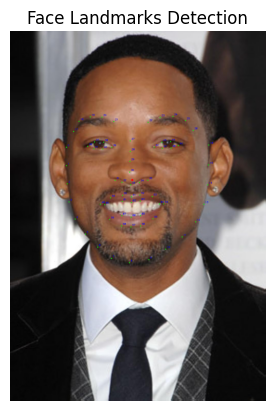

In [39]:
import dlib
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained face landmark predictor model
predictor_path = "data/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)

# Load the pre-trained face detector model
detector_face = dlib.get_frontal_face_detector()

# Load an image
image_path = "will.jpg"
image = cv2.imread(image_path)

# Convert the image to grayscale (required by Dlib)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector_face(gray)

# Loop through each face and detect landmarks
for face in faces:
    landmarks = predictor(gray, face)

    # Draw landmarks on the image
    for i in range(68):
        x, y = landmarks.part(i).x, landmarks.part(i).y
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)  # Draw a green circle for each landmark
        cv2.putText(image, str(i), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

    landmarks_coordinates = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])
    middle_point = np.mean(landmarks_coordinates, axis=0).astype(int)

    # Draw a circle at the middle point on the image
    cv2.circle(image, tuple(middle_point), 4, (0, 0, 255), -1)

# Convert BGR image to RGB for displaying with pyplot
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the result using pyplot
plt.imshow(image_rgb)
plt.title("Face Landmarks Detection")
plt.axis("off")  # Turn off axis labels
plt.show()


In [40]:
# Supponiamo che landmarks_coordinates sia l'array delle coordinate
landmarks_coordinates = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

all_landmark = []
vec_comb_lin_x = []
vec_comb_lin_y = []

# Dividi l'array in coordinate x e y
land_x = landmarks_coordinates[:, 0]  # Estrae tutte le colonne 0 (coordinate x)
land_y = landmarks_coordinates[:, 1]  # Estrae tutte le colonne 1 (coordinate y)

for i in range(68):
    sum_x = 0
    sum_y = 0

    for j in range(68):
      sum_x = sum_x + land_x[i] * (1/land_x[j])
      sum_y = sum_y + land_y[i] * (1/land_y[j])

    vec_comb_lin_x.append(sum_x)
    vec_comb_lin_y.append(sum_y)

all_landmark = vec_comb_lin_x + vec_comb_lin_y

In [41]:
columns_names = [f'Landmark_x_{i}' for i in range(68)]
columns_names1 = [f'Landmark_y_{i}' for i in range(68)]

all_columns_names = columns_names + columns_names1

test_df = pd.DataFrame([all_landmark], columns=all_columns_names)

In [67]:
pred = model.predict(test_df)
pred

1/1 [==============================] - 0s 20ms/step


array([[ 0.3120126 ,  0.32860428,  0.25508118,  0.19041109,  1.6431276 ,
         1.4268074 ,  1.0517149 ,  1.6763566 ,  0.27564302,  1.9132034 ,
         1.1997375 , -0.05137002, -0.00753626,  1.393965  , -0.15552217,
        -0.16441983,  1.0105008 ,  0.45943496, -0.11880568,  0.5180964 ]],
      dtype=float32)

In [68]:
aus_list = np.array([value[0] for key, value in single_face_prediction.aus.to_dict().items()])
print(aus_list)

[0.68068308 0.49225131 0.21370329 0.30096534 0.94260103 1.
 0.46944541 0.9928     1.         0.98160458 0.64530909 0.48352721
 0.20159455 1.         0.19791234 0.00998374 0.99997699 0.66221792
 0.06673186 0.41662848]


In [69]:
bin_pred = (pred >= 0.475).astype(int)
bin_pred

array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])

In [70]:
bin_aus = (aus_list >= 0.5).astype(int)
bin_aus

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [71]:
emotions = {'happiness': [4, 9], 'sadness': [0, 2, 11], 'surprise': [0, 1, 3, 17], 'fear': [0, 1, 2, 3, 5, 13, 17], 'anger': [2, 3, 5, 14]}

emotion = 'neutral'
diff_temp = 0

for key, value in emotions.items():
  sum = 0
  v_len = len(value)/2

  for v in value:
    if pred[0][v] >= 0.48:
      sum = sum + 1

  diff = sum - v_len

  if diff >= diff_temp:
    emotion = key
    diff_temp = sum - v_len


In [72]:
emotion

'happiness'

# Emotion Confront

In [93]:
from tensorflow.keras.models import load_model

loaded_model = load_model('data/au_pred_model.h5')

In [ ]:
import pandas as pd

afew_keyframes_df = pd.read_csv('data/afew_keyframes.csv')

In [ ]:
len(afew_keyframes_df)

6000

In [ ]:
aus_names_list = merged_df.columns.to_list()[136:]

In [84]:
X_emotion = merged_df
y_emotion = merged_df[aus_names_list]

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_emotion, y_emotion, test_size=0.2, random_state=42)

In [ ]:
X_test.columns[137]

'AU01'

In [86]:
def predict_emotion(prediction):
    emotions = {'happiness': [4, 9], 'sadness': [0, 2, 11], 'surprise': [0, 1, 3, 17], 'fear': [0, 1, 2, 3, 5, 13, 17], 'anger': [2, 3, 5, 14]}

    emotion = 'neutral'
    diff_temp = 0

    for key, value in emotions.items():
      sum = 0
      v_len = len(value)/2

      for v in value:
        if prediction[v] >= 0.47:
          sum = sum + 1

      diff = sum - v_len

      if diff >= diff_temp:
        emotion = key
        diff_temp = sum - v_len

    return emotion

In [87]:
def prediction_emotion_pyfeat_au():
  emotions_aus_list = []

  for index, row in X_test.iterrows():
    aus_list = row.to_list()[137:157]
    true_pred = predict_emotion(aus_list)

    emotions_aus_list.append(true_pred)

  return emotions_aus_list

In [88]:
def merge_fear_surprise(emotion_list):
  # Cambia 'fear' con 'fear-surprise'
  for i in range(len(emotion_list)):
      if emotion_list[i] == 'fear' or emotion_list[i] == 'surprise':
          emotion_list[i] = 'fear-surprise'

  return emotion_list

In [89]:
def get_categorical_values(emotion_list):
  # Dizionario di mapping per le categorie
  mapping_categorie_numeriche = {
      "happiness": 0,
      "fear-surprise": 1,
      "sadness": 2,
      "neutral": 3,
      "anger": 4,
  }

  # Funzione per categorizzare una stringa restituendo il numero corrispondente
  def categorizza_stringa_numerica(stringa, mapping):
      for categoria, numero in mapping.items():
          if stringa in categoria:
              return numero
      return 0  # 0 per sconosciuto o nessuna corrispondenza

  # Categorizza ogni stringa nella lista
  emotions_au = [categorizza_stringa_numerica(stringa, mapping_categorie_numeriche) for stringa in emotion_list]

  return emotions_au

In [90]:
def predict_emotion_our_au():
  pred = []

  for index, row in X_test.iterrows():

    directory_path, file_name = os.path.split(row['image_path'])
    directory_path = directory_path.replace('_resized', '')
    json_name = directory_path.split('/')[3]
    file_name = file_name.split('.')[0]

    json_path = f'{directory_path}/{json_name}.json'
    with open(json_path, 'r') as file:
        json_data = json.load(file)

    landmarks = json_data['frames'][file_name]['landmarks']

    vec_comb_lin_x = []
    vec_comb_lin_y = []

    land_x = np.array([int(x) for x, _ in landmarks])
    land_y = np.array([int(y) for _, y in landmarks])
        #print(f"Landmark {idx + 1}: ({x}, {y})")

    for i in range(68):
      sum_x = 0
      sum_y = 0

      for j in range(68):
        sum_x = sum_x + land_x[i] * (1/land_x[j])
        sum_y = sum_y + land_y[i] * (1/land_y[j])

      vec_comb_lin_x.append(sum_x)
      vec_comb_lin_y.append(sum_y)

    all_landmark = vec_comb_lin_x + vec_comb_lin_y

    landmarks_df = pd.DataFrame([all_landmark], columns=all_columns_names)
    prediction = loaded_model.predict(landmarks_df, verbose=False)

    pred.append(predict_emotion(prediction[0]))

  return pred

In [94]:
from sklearn.metrics import accuracy_score

threshold = 0.40
max = 0
best_threshold = 0

emotion_pyfeat_au_list = prediction_emotion_pyfeat_au()
emotion_our_au_list = predict_emotion_our_au()

merged_emotion_pyfeat_au_list = merge_fear_surprise(emotion_pyfeat_au_list)
merged_emotion_our_au_list = merge_fear_surprise(emotion_our_au_list)

cat_pyfeat_emotion = get_categorical_values(merged_emotion_pyfeat_au_list)
cat_our_emotion = get_categorical_values(merged_emotion_our_au_list)

accuracy = accuracy_score(cat_pyfeat_emotion, cat_our_emotion)
print(accuracy)

0.43666666666666665


In [95]:
from sklearn.metrics import classification_report

print(classification_report(cat_pyfeat_emotion, cat_our_emotion))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61       135
           1       0.46      0.48      0.47       376
           2       0.33      0.45      0.38       260
           3       0.05      0.02      0.03        89
           4       0.49      0.45      0.47       340

    accuracy                           0.44      1200
   macro avg       0.40      0.39      0.39      1200
weighted avg       0.44      0.44      0.43      1200



# Recompute AUs for the entire dataset(using our model)

In [ ]:
import cv2
import numpy as np
import dlib
import pandas as pd

def detect_landmarks(image_path):
    # Load the pre-trained face detector model
    detector_face = dlib.get_frontal_face_detector()
    predictor_path = "shape_predictor_68_face_landmarks.dat"
    predictor = dlib.shape_predictor(predictor_path)
    # Load an image
    image = cv2.imread(image_path)

    # Convert the image to grayscale (required by Dlib)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector_face(gray)

    landmarks = predictor(gray, faces[0])
    landmarks_coordinates = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

    return landmarks_coordinates


def landmarks_combination_df(landmarks):
    columns_names = [f'Landmark_x_{i}' for i in range(68)]
    columns_names1 = [f'Landmark_y_{i}' for i in range(68)]

    all_columns_names = columns_names + columns_names1

    vec_comb_lin_x = []
    vec_comb_lin_y = []

    # Dividi l'array in coordinate x e y
    land_x = landmarks[:, 0]  # Estrae tutte le colonne 0 (coordinate x)
    land_y = landmarks[:, 1]  # Estrae tutte le colonne 1 (coordinate y)

    for i in range(68):
        sum_x = 0
        sum_y = 0

        for j in range(68):
            sum_x = sum_x + land_x[i] * (1 / land_x[j])
            sum_y = sum_y + land_y[i] * (1 / land_y[j])

        vec_comb_lin_x.append(sum_x)
        vec_comb_lin_y.append(sum_y)

    all_landmark = vec_comb_lin_x + vec_comb_lin_y

    return pd.DataFrame([all_landmark], columns=all_columns_names)

In [ ]:
import os
import pandas as pd
import json
from tensorflow.keras.models import load_model

def process_all_images(folder_path, start_folder=0, end_folder=None):
    """
    Processa tutte le immagini in un dato percorso per estrarre le Action Units (AU).

    :param folder_path: Percorso della cartella contenente le immagini.
    :param start_folder: Indice della sotto-cartella da cui iniziare l'elaborazione.
    :param end_folder: Indice della sotto-cartella in cui fermare l'elaborazione (esclusiva).
    :return: DataFrame con i valori delle AU per ogni immagine processata.
    """
    aus_results = []
    au_pred_model = load_model('data/au_pred_model1.h5')
    sorted_folders = sorted(os.listdir(folder_path))

    # Se end_folder non è specificato, processa fino all'ultima cartella
    if end_folder is None:
        end_folder = len(sorted_folders)

    # Processa solo le cartelle nell'intervallo specificato
    for folder_index, folder_name in enumerate(sorted_folders[start_folder:end_folder], start_folder):
        subfolder_path = os.path.join(folder_path, folder_name)
        print(f"Elaborazione della sotto-cartella: {subfolder_path}")

        if not os.path.isdir(subfolder_path):
            print(f"Non è una cartella: {subfolder_path}")
            continue

        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue  # Process only image files

            try:
                # Esegui la detection delle AU
                landmarks = detect_landmarks(image_path)
                if len(landmarks) > 0:
                    landmarks_df = landmarks_combination_df(landmarks)
                    prediction = au_pred_model.predict(landmarks_df,verbose=0)
                    au_values = prediction[0]  # Presumiamo che questo sia un array con le previsioni delle AU

                # Crea un dizionario dalle previsioni delle AU utilizzando indici numerici come chiavi
                au_dict = {'AU' + str(index + 1): value for index, value in enumerate(au_values)}

                # Crea il dizionario finale aggiungendo il percorso dell'immagine
                au_values_with_path = {'image_path': image_path, **au_dict}
                aus_results.append(au_values_with_path)
            except Exception as e:
                print(f"Errore durante l'elaborazione di {image_path}: {e}")

    return pd.DataFrame(aus_results)




In [ ]:
# Percorso della cartella principale del dataset
dataset_path = "/content/dataset_resized/"

# Processa le immagini nel dataset
# Puoi modificare 'max_folders' in base al numero di sotto-cartelle che vuoi processare
aus_data = process_all_images(dataset_path,0,600)

# Stampa i primi record per avere un'anteprima dei dati
print(aus_data.head())

In [ ]:
aus_data.to_csv('afew_0_600.csv')

# Arousal and Valence Model

In [118]:
import pandas as pd

new_aus_df = pd.read_csv('data/afew_keyframes.csv')

In [119]:
new_aus_df = new_aus_df.dropna()

In [120]:
new_aus_df

,image_path,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,...,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43,arousal,valence
0,/content/dataset_resized/401/00015.png,0.311357,0.135927,0.798931,0.328358,0.113616,1.0,0.493366,0.029253,0.0,...,0.257176,1.0,0.719543,0.268569,0.993881,0.885669,0.501640,0.786895,1.0,-1.0
1,/content/dataset_resized/401/00016.png,0.291428,0.148411,0.881824,0.365231,0.104657,1.0,0.360925,0.062726,0.0,...,0.327704,1.0,0.655670,0.382354,0.990813,0.953209,0.437312,0.711133,1.0,-1.0
2,/content/dataset_resized/401/00018.png,0.340948,0.113658,0.831665,0.340745,0.084021,0.0,0.353916,0.018393,0.0,...,0.309095,1.0,0.407399,0.346851,0.978948,0.869907,0.266384,0.741665,1.0,-1.0
3,/content/dataset_resized/401/00031.png,0.291201,0.127205,0.756636,0.326717,0.118116,0.0,0.433923,0.005935,0.0,...,0.297202,1.0,0.264385,0.346684,0.999072,0.740485,0.712587,0.701903,2.0,-1.0
4,/content/dataset_resized/401/00046.png,0.360045,0.199449,0.859479,0.252883,0.122171,1.0,0.447879,0.063832,0.0,...,0.340059,1.0,0.582021,0.231151,0.994853,0.659481,0.780542,0.535933,2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,/content/dataset_resized/200/00020.png,0.422657,0.050986,0.963368,0.253873,0.370320,1.0,0.270748,0.697472,1.0,...,0.539658,0.0,0.722313,0.064561,0.998532,0.746642,0.063520,0.549602,3.0,-1.0
5996,/content/dataset_resized/200/00021.png,0.421654,0.109469,0.965105,0.249666,0.180396,1.0,0.282195,0.023396,1.0,...,0.545938,0.0,0.603435,0.156507,0.986948,0.566380,0.103323,0.467108,3.0,-1.0
5997,/content/dataset_resized/200/00059.png,0.451566,0.175831,0.896503,0.529105,0.116464,0.0,0.126099,0.014512,1.0,...,0.508652,0.0,0.459939,0.352326,0.965488,0.837143,0.633322,0.098899,2.0,0.0
5998,/content/dataset_resized/200/00067.png,0.608986,0.194725,0.704085,0.423611,0.285823,0.0,0.158707,0.843249,1.0,...,0.545037,0.0,0.535025,0.066318,0.992853,0.892109,0.421667,0.059766,2.0,0.0


In [121]:
def predict_emotion(prediction):
    emotions = {'happiness': [4, 9], 'sadness': [0, 2, 11], 'surprise': [0, 1, 3, 17], 'fear': [0, 1, 2, 3, 5, 13, 17], 'anger': [2, 3, 5, 14]}

    emotion = 'neutral'
    diff_temp = 0

    for key, value in emotions.items():
      sum = 0
      v_len = len(value)/2

      for v in value:
        if prediction[v] >= 0.48:
          sum = sum + 1

      diff = sum - v_len

      if diff >= diff_temp:
        emotion = key
        diff_temp = sum - v_len

    return emotion

In [122]:
import os

arousal = []
valence = []
emotion = []

for index, row in new_aus_df.iterrows():
  directory_path, file_name = os.path.split(row['image_path'])
  directory_path = directory_path.replace('_resized', '')
  json_name = directory_path.split('/')[3]
  file_name = file_name.split('.')[0]

  json_path = f'{directory_path}/{json_name}.json'
  with open(json_path, 'r') as file:
      json_data = json.load(file)


  arousal.append(json_data['frames'][file_name]['arousal'])
  valence.append(json_data['frames'][file_name]['valence'])
  emotion.append(predict_emotion(row.to_list()[2:]))

In [123]:
new_aus_df['arousal'] = arousal
new_aus_df['valence'] = valence
new_aus_df['emotion'] = emotion

In [124]:
new_aus_df

,image_path,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,...,AU20,AU23,AU24,AU25,AU26,AU28,AU43,arousal,valence,emotion
0,/content/dataset_resized/401/00015.png,0.311357,0.135927,0.798931,0.328358,0.113616,1.0,0.493366,0.029253,0.0,...,1.0,0.719543,0.268569,0.993881,0.885669,0.501640,0.786895,1.0,-1.0,fear
1,/content/dataset_resized/401/00016.png,0.291428,0.148411,0.881824,0.365231,0.104657,1.0,0.360925,0.062726,0.0,...,1.0,0.655670,0.382354,0.990813,0.953209,0.437312,0.711133,1.0,-1.0,happiness
2,/content/dataset_resized/401/00018.png,0.340948,0.113658,0.831665,0.340745,0.084021,0.0,0.353916,0.018393,0.0,...,1.0,0.407399,0.346851,0.978948,0.869907,0.266384,0.741665,1.0,-1.0,neutral
3,/content/dataset_resized/401/00031.png,0.291201,0.127205,0.756636,0.326717,0.118116,0.0,0.433923,0.005935,0.0,...,1.0,0.264385,0.346684,0.999072,0.740485,0.712587,0.701903,2.0,-1.0,surprise
4,/content/dataset_resized/401/00046.png,0.360045,0.199449,0.859479,0.252883,0.122171,1.0,0.447879,0.063832,0.0,...,1.0,0.582021,0.231151,0.994853,0.659481,0.780542,0.535933,2.0,-1.0,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,/content/dataset_resized/200/00020.png,0.422657,0.050986,0.963368,0.253873,0.370320,1.0,0.270748,0.697472,1.0,...,0.0,0.722313,0.064561,0.998532,0.746642,0.063520,0.549602,3.0,-1.0,happiness
5996,/content/dataset_resized/200/00021.png,0.421654,0.109469,0.965105,0.249666,0.180396,1.0,0.282195,0.023396,1.0,...,0.0,0.603435,0.156507,0.986948,0.566380,0.103323,0.467108,3.0,-1.0,happiness
5997,/content/dataset_resized/200/00059.png,0.451566,0.175831,0.896503,0.529105,0.116464,0.0,0.126099,0.014512,1.0,...,0.0,0.459939,0.352326,0.965488,0.837143,0.633322,0.098899,2.0,0.0,sadness
5998,/content/dataset_resized/200/00067.png,0.608986,0.194725,0.704085,0.423611,0.285823,0.0,0.158707,0.843249,1.0,...,0.0,0.535025,0.066318,0.992853,0.892109,0.421667,0.059766,2.0,0.0,neutral


In [125]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Creazione del modello con i nuovi parametri
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(26,)))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.14627773253137555))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3104964013629035))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4514332549580662))

model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.43080782555839275))

# Output layer con 2 neuroni per le 2 variabili target e attivazione lineare
model.add(layers.Dense(2, activation='linear'))

# Definizione del programma di decadimento esponenziale del learning rate
initial_learning_rate = 0.0005315067319714526
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

# Cambio dell'ottimizzatore a RMSprop con learning rate schedule
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

# Cambio della loss function a 'huber_loss'
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.LogCosh(),
              metrics=['mae'])

# Stampa della struttura del modello
model.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_347 (Dense)           (None, 128)               3456      
                                                                 
 batch_normalization_289 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dropout_289 (Dropout)       (None, 128)               0         
                                                                 
 dense_348 (Dense)           (None, 64)                8256      
                                                                 
 batch_normalization_290 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 dropout_290 (Dropout)       (None, 64)              

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Function to create and compile the model
def create_model(trial):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(20,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_4', 0.1, 0.9)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(trial.suggest_uniform('dropout_5', 0.1, 0.9)))
    model.add(layers.Dense(2, activation='linear'))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)
    lr_schedule = ExponentialDecay(learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.LogCosh(), metrics=['mae'])

    return model

# Objective function for Optuna
def objective(trial):
    model = create_model(trial)

    # Training the model
    history = model.fit(X_train, y_train, epochs=trial.suggest_categorical('epochs', [50, 100, 150, 200]),
                        batch_size=trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
                        validation_split=0.2)

    # Evaluation on the validation set
    val_loss = history.history['val_loss'][-1]

    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run hyperparameter optimization
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-01-27 11:08:37,727] A new study created in memory with name: no-name-9ce514b9-757d-4f65-80b1-d8b4d8139c64
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_4', 0.1, 0.

Epoch 1/150
27/27 [==============================] - 3s 30ms/step - loss: 1.3159 - mae: 1.8296 - val_loss: 1.2483 - val_mae: 1.7112
Epoch 2/150
27/27 [==============================] - 0s 10ms/step - loss: 1.1828 - mae: 1.6796 - val_loss: 1.1711 - val_mae: 1.6440
Epoch 3/150
27/27 [==============================] - 0s 9ms/step - loss: 1.1491 - mae: 1.6406 - val_loss: 1.1413 - val_mae: 1.6131
Epoch 4/150
27/27 [==============================] - 0s 9ms/step - loss: 1.1051 - mae: 1.5926 - val_loss: 1.1203 - val_mae: 1.6108
Epoch 5/150
27/27 [==============================] - 0s 11ms/step - loss: 1.1028 - mae: 1.5901 - val_loss: 1.1495 - val_mae: 1.6621
Epoch 6/150
27/27 [==============================] - 0s 9ms/step - loss: 1.0877 - mae: 1.5738 - val_loss: 1.1187 - val_mae: 1.6310
Epoch 7/150
27/27 [==============================] - 0s 9ms/step - loss: 1.0955 - mae: 1.5821 - val_loss: 1.1265 - val_mae: 1.6410
Epoch 8/150
27/27 [==============================] - 0s 9ms/step - loss: 1.0823 

[I 2024-01-27 11:09:25,998] Trial 0 finished with value: 1.08600652217865 and parameters: {'dropout_2': 0.7006430636057989, 'dropout_3': 0.6224749648646567, 'dropout_4': 0.23249422169819944, 'dropout_5': 0.19701895000514755, 'learning_rate': 0.007599153905170674, 'epochs': 150, 'batch_size': 128}. Best is trial 0 with value: 1.08600652217865.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_un

Epoch 1/100
108/108 [==============================] - 3s 7ms/step - loss: 1.3400 - mae: 1.8284 - val_loss: 1.2640 - val_mae: 1.7297
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 1.2582 - mae: 1.7480 - val_loss: 1.1970 - val_mae: 1.6615
Epoch 3/100
108/108 [==============================] - 1s 5ms/step - loss: 1.2232 - mae: 1.7144 - val_loss: 1.2062 - val_mae: 1.6644
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 1.2051 - mae: 1.6962 - val_loss: 1.1956 - val_mae: 1.7197
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 1.2039 - mae: 1.6938 - val_loss: 1.2256 - val_mae: 1.7283
Epoch 6/100
108/108 [==============================] - 1s 7ms/step - loss: 1.1892 - mae: 1.6776 - val_loss: 1.2370 - val_mae: 1.7141
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1965 - mae: 1.6834 - val_loss: 1.1985 - val_mae: 1.7301
Epoch 8/100
108/108 [==============================] - 1s 5ms/step - 

[I 2024-01-27 11:10:26,488] Trial 1 finished with value: 1.1561261415481567 and parameters: {'dropout_2': 0.8818604491589114, 'dropout_3': 0.3359364727035885, 'dropout_4': 0.4693389984089641, 'dropout_5': 0.4451976562910088, 'learning_rate': 0.047140428906063035, 'epochs': 100, 'batch_size': 32}. Best is trial 0 with value: 1.08600652217865.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_uni

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.6970 - mae: 2.2649 - val_loss: 1.3972 - val_mae: 1.9625
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5383 - mae: 2.0962 - val_loss: 1.3870 - val_mae: 1.9596
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 1.4191 - mae: 1.9655 - val_loss: 1.2938 - val_mae: 1.8394
Epoch 4/200
108/108 [==============================] - 1s 7ms/step - loss: 1.3304 - mae: 1.8641 - val_loss: 1.2365 - val_mae: 1.7592
Epoch 5/200
108/108 [==============================] - 1s 8ms/step - loss: 1.2702 - mae: 1.7994 - val_loss: 1.2309 - val_mae: 1.7513
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2322 - mae: 1.7503 - val_loss: 1.1809 - val_mae: 1.6825
Epoch 7/200
108/108 [==============================] - 1s 8ms/step - loss: 1.2083 - mae: 1.7269 - val_loss: 1.1885 - val_mae: 1.6907
Epoch 8/200
108/108 [==============================] - 1s 7ms/step - 

[I 2024-01-27 11:12:50,591] Trial 2 finished with value: 0.8499419093132019 and parameters: {'dropout_2': 0.12660488892290706, 'dropout_3': 0.2724244164102639, 'dropout_4': 0.45940450739038996, 'dropout_5': 0.5279036824438129, 'learning_rate': 0.0005969147545719836, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/50
27/27 [==============================] - 2s 17ms/step - loss: 1.9606 - mae: 2.5304 - val_loss: 1.3703 - val_mae: 1.8446
Epoch 2/50
27/27 [==============================] - 0s 6ms/step - loss: 1.7590 - mae: 2.3142 - val_loss: 1.3651 - val_mae: 1.8385
Epoch 3/50
27/27 [==============================] - 0s 6ms/step - loss: 1.6374 - mae: 2.1748 - val_loss: 1.3361 - val_mae: 1.8003
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 1.5475 - mae: 2.0723 - val_loss: 1.3120 - val_mae: 1.7598
Epoch 5/50
27/27 [==============================] - 0s 6ms/step - loss: 1.4391 - mae: 1.9497 - val_loss: 1.3014 - val_mae: 1.7452
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 1.3865 - mae: 1.8832 - val_loss: 1.2990 - val_mae: 1.7457
Epoch 7/50
27/27 [==============================] - 0s 6ms/step - loss: 1.3325 - mae: 1.8250 - val_loss: 1.2785 - val_mae: 1.7299
Epoch 8/50
27/27 [==============================] - 0s 6ms/step - loss: 1.3119 - mae: 1.7

[I 2024-01-27 11:13:03,036] Trial 3 finished with value: 1.0695406198501587 and parameters: {'dropout_2': 0.5174071492451139, 'dropout_3': 0.5764396352717818, 'dropout_4': 0.15378803737924118, 'dropout_5': 0.7899203674675022, 'learning_rate': 0.0017533373355705887, 'epochs': 50, 'batch_size': 128}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest

Epoch 1/150
108/108 [==============================] - 3s 11ms/step - loss: 1.4691 - mae: 1.9850 - val_loss: 1.2708 - val_mae: 1.7324
Epoch 2/150
108/108 [==============================] - 1s 7ms/step - loss: 1.2396 - mae: 1.7226 - val_loss: 1.1876 - val_mae: 1.6386
Epoch 3/150
108/108 [==============================] - 1s 7ms/step - loss: 1.2128 - mae: 1.6948 - val_loss: 1.1641 - val_mae: 1.6420
Epoch 4/150
108/108 [==============================] - 1s 8ms/step - loss: 1.2056 - mae: 1.6870 - val_loss: 1.1892 - val_mae: 1.6554
Epoch 5/150
108/108 [==============================] - 0s 4ms/step - loss: 1.1776 - mae: 1.6541 - val_loss: 1.1716 - val_mae: 1.6461
Epoch 6/150
108/108 [==============================] - 0s 4ms/step - loss: 1.1768 - mae: 1.6540 - val_loss: 1.2097 - val_mae: 1.6940
Epoch 7/150
108/108 [==============================] - 0s 4ms/step - loss: 1.1923 - mae: 1.6764 - val_loss: 1.1761 - val_mae: 1.6602
Epoch 8/150
108/108 [==============================] - 0s 4ms/step -

[I 2024-01-27 11:14:23,271] Trial 4 finished with value: 1.1321735382080078 and parameters: {'dropout_2': 0.3057080372068943, 'dropout_3': 0.4320531328329511, 'dropout_4': 0.7859195034295398, 'dropout_5': 0.8146202912492456, 'learning_rate': 0.00944365337727558, 'epochs': 150, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_un

Epoch 1/50


<ipython-input-29-50718b8ee584>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)


27/27 [==============================] - 2s 16ms/step - loss: 1.6387 - mae: 2.1931 - val_loss: 1.3462 - val_mae: 1.8091
Epoch 2/50
27/27 [==============================] - 0s 7ms/step - loss: 1.6366 - mae: 2.1913 - val_loss: 1.3410 - val_mae: 1.8153
Epoch 3/50
27/27 [==============================] - 0s 6ms/step - loss: 1.6128 - mae: 2.1635 - val_loss: 1.3392 - val_mae: 1.8221
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 1.6217 - mae: 2.1740 - val_loss: 1.3393 - val_mae: 1.8252
Epoch 5/50
27/27 [==============================] - 0s 6ms/step - loss: 1.6114 - mae: 2.1629 - val_loss: 1.3412 - val_mae: 1.8321
Epoch 6/50
27/27 [==============================] - 0s 7ms/step - loss: 1.6174 - mae: 2.1676 - val_loss: 1.3443 - val_mae: 1.8417
Epoch 7/50
27/27 [==============================] - 0s 6ms/step - loss: 1.6207 - mae: 2.1740 - val_loss: 1.3454 - val_mae: 1.8455
Epoch 8/50
27/27 [==============================] - 0s 7ms/step - loss: 1.6226 - mae: 2.1774 - val_l

[I 2024-01-27 11:14:35,028] Trial 5 finished with value: 1.3367536067962646 and parameters: {'dropout_2': 0.3115901401618232, 'dropout_3': 0.8532798303853334, 'dropout_4': 0.6719186186168714, 'dropout_5': 0.14746943735601176, 'learning_rate': 2.3577244010605868e-06, 'epochs': 50, 'batch_size': 128}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/50


<ipython-input-29-50718b8ee584>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)


54/54 [==============================] - 3s 11ms/step - loss: 1.4884 - mae: 2.0252 - val_loss: 1.3232 - val_mae: 1.7823
Epoch 2/50
54/54 [==============================] - 0s 5ms/step - loss: 1.3422 - mae: 1.8496 - val_loss: 1.2932 - val_mae: 1.7655
Epoch 3/50
54/54 [==============================] - 0s 5ms/step - loss: 1.2447 - mae: 1.7363 - val_loss: 1.2642 - val_mae: 1.7524
Epoch 4/50
54/54 [==============================] - 0s 5ms/step - loss: 1.2153 - mae: 1.7033 - val_loss: 1.2320 - val_mae: 1.6974
Epoch 5/50
54/54 [==============================] - 0s 5ms/step - loss: 1.1774 - mae: 1.6574 - val_loss: 1.1895 - val_mae: 1.6677
Epoch 6/50
54/54 [==============================] - 0s 5ms/step - loss: 1.1752 - mae: 1.6538 - val_loss: 1.1816 - val_mae: 1.6596
Epoch 7/50
54/54 [==============================] - 0s 5ms/step - loss: 1.1503 - mae: 1.6341 - val_loss: 1.1645 - val_mae: 1.6600
Epoch 8/50
54/54 [==============================] - 0s 5ms/step - loss: 1.1419 - mae: 1.6294 - val_l

[I 2024-01-27 11:14:54,583] Trial 6 finished with value: 1.1355676651000977 and parameters: {'dropout_2': 0.8346962059898396, 'dropout_3': 0.5655195934399094, 'dropout_4': 0.6774368333331884, 'dropout_5': 0.2909050876733682, 'learning_rate': 0.00466171077821025, 'epochs': 50, 'batch_size': 64}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_uni

Epoch 1/100
14/14 [==============================] - 2s 30ms/step - loss: 1.3241 - mae: 1.8189 - val_loss: 4.4744 - val_mae: 5.1097
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 1.1869 - mae: 1.6657 - val_loss: 2.9780 - val_mae: 3.5176
Epoch 3/100
14/14 [==============================] - 0s 11ms/step - loss: 1.1731 - mae: 1.6487 - val_loss: 1.5988 - val_mae: 2.1498
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 1.1583 - mae: 1.6352 - val_loss: 2.2425 - val_mae: 2.8042
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 1.1616 - mae: 1.6455 - val_loss: 1.5430 - val_mae: 2.0841
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 1.1376 - mae: 1.6214 - val_loss: 1.4270 - val_mae: 1.9396
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 1.1226 - mae: 1.6042 - val_loss: 1.1954 - val_mae: 1.6968
Epoch 8/100
14/14 [==============================] - 0s 10ms/step - loss: 1.1194 

[I 2024-01-27 11:15:17,198] Trial 7 finished with value: 1.1048541069030762 and parameters: {'dropout_2': 0.34619264205547673, 'dropout_3': 0.45637032184773063, 'dropout_4': 0.6393921589504694, 'dropout_5': 0.6689420864253318, 'learning_rate': 0.04347149625757992, 'epochs': 100, 'batch_size': 256}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest

Epoch 1/150
108/108 [==============================] - 4s 10ms/step - loss: 1.3777 - mae: 1.8854 - val_loss: 1.3387 - val_mae: 1.8204
Epoch 2/150
108/108 [==============================] - 0s 4ms/step - loss: 1.3220 - mae: 1.8031 - val_loss: 1.3315 - val_mae: 1.8051
Epoch 3/150
108/108 [==============================] - 0s 4ms/step - loss: 1.3135 - mae: 1.7943 - val_loss: 1.3092 - val_mae: 1.7954
Epoch 4/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2699 - mae: 1.7507 - val_loss: 1.2326 - val_mae: 1.7106
Epoch 5/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2352 - mae: 1.7157 - val_loss: 1.2009 - val_mae: 1.6708
Epoch 6/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2307 - mae: 1.7099 - val_loss: 1.2162 - val_mae: 1.6562
Epoch 7/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2105 - mae: 1.6886 - val_loss: 1.2496 - val_mae: 1.7403
Epoch 8/150
108/108 [==============================] - 0s 4ms/step -

[I 2024-01-27 11:16:40,029] Trial 8 finished with value: 1.21396005153656 and parameters: {'dropout_2': 0.8032493320042025, 'dropout_3': 0.860697449113168, 'dropout_4': 0.8516654732930746, 'dropout_5': 0.30475098957748425, 'learning_rate': 0.01204680472341688, 'epochs': 150, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_unif

Epoch 1/50
54/54 [==============================] - 3s 15ms/step - loss: 1.5790 - mae: 2.1320 - val_loss: 1.3513 - val_mae: 1.8446
Epoch 2/50
54/54 [==============================] - 0s 8ms/step - loss: 1.4486 - mae: 1.9886 - val_loss: 1.3546 - val_mae: 1.8597
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 1.3635 - mae: 1.8903 - val_loss: 1.3382 - val_mae: 1.8390
Epoch 4/50
54/54 [==============================] - 0s 5ms/step - loss: 1.2923 - mae: 1.8127 - val_loss: 1.3229 - val_mae: 1.8273
Epoch 5/50
54/54 [==============================] - 0s 5ms/step - loss: 1.2553 - mae: 1.7654 - val_loss: 1.2996 - val_mae: 1.8109
Epoch 6/50
54/54 [==============================] - 0s 5ms/step - loss: 1.2173 - mae: 1.7218 - val_loss: 1.2810 - val_mae: 1.7991
Epoch 7/50
54/54 [==============================] - 0s 5ms/step - loss: 1.2007 - mae: 1.7048 - val_loss: 1.2680 - val_mae: 1.7848
Epoch 8/50
54/54 [==============================] - 0s 4ms/step - loss: 1.1725 - mae: 1.6

[I 2024-01-27 11:16:59,869] Trial 9 finished with value: 1.0648491382598877 and parameters: {'dropout_2': 0.4756894474801202, 'dropout_3': 0.3827600023474532, 'dropout_4': 0.7261870957016199, 'dropout_5': 0.12334967791219108, 'learning_rate': 0.0008915990669741432, 'epochs': 50, 'batch_size': 64}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_

Epoch 1/200
14/14 [==============================] - 3s 31ms/step - loss: 1.7812 - mae: 2.3513 - val_loss: 1.3484 - val_mae: 1.8169
Epoch 2/200
14/14 [==============================] - 0s 9ms/step - loss: 1.7387 - mae: 2.3014 - val_loss: 1.3421 - val_mae: 1.8247
Epoch 3/200
14/14 [==============================] - 0s 10ms/step - loss: 1.7568 - mae: 2.3227 - val_loss: 1.3370 - val_mae: 1.8242
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 1.7142 - mae: 2.2796 - val_loss: 1.3317 - val_mae: 1.8233
Epoch 5/200
14/14 [==============================] - 0s 10ms/step - loss: 1.6897 - mae: 2.2522 - val_loss: 1.3277 - val_mae: 1.8231
Epoch 6/200
14/14 [==============================] - 0s 10ms/step - loss: 1.6888 - mae: 2.2493 - val_loss: 1.3242 - val_mae: 1.8224
Epoch 7/200
14/14 [==============================] - 0s 10ms/step - loss: 1.6712 - mae: 2.2314 - val_loss: 1.3203 - val_mae: 1.8209
Epoch 8/200
14/14 [==============================] - 0s 13ms/step - loss: 1.6

[I 2024-01-27 11:17:35,767] Trial 10 finished with value: 1.0687990188598633 and parameters: {'dropout_2': 0.1281802419617952, 'dropout_3': 0.10673656780014812, 'dropout_4': 0.414915502027238, 'dropout_5': 0.5846709157830872, 'learning_rate': 5.8375355062184674e-05, 'epochs': 200, 'batch_size': 256}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugge

Epoch 1/200
54/54 [==============================] - 3s 15ms/step - loss: 1.7305 - mae: 2.3041 - val_loss: 1.3220 - val_mae: 1.8267
Epoch 2/200
54/54 [==============================] - 0s 8ms/step - loss: 1.6045 - mae: 2.1755 - val_loss: 1.3408 - val_mae: 1.8737
Epoch 3/200
54/54 [==============================] - 1s 12ms/step - loss: 1.4869 - mae: 2.0452 - val_loss: 1.3264 - val_mae: 1.8594
Epoch 4/200
54/54 [==============================] - 0s 8ms/step - loss: 1.4656 - mae: 2.0186 - val_loss: 1.2957 - val_mae: 1.8253
Epoch 5/200
54/54 [==============================] - 0s 9ms/step - loss: 1.4368 - mae: 1.9914 - val_loss: 1.2597 - val_mae: 1.7849
Epoch 6/200
54/54 [==============================] - 0s 8ms/step - loss: 1.3714 - mae: 1.9183 - val_loss: 1.2204 - val_mae: 1.7354
Epoch 7/200
54/54 [==============================] - 0s 6ms/step - loss: 1.3633 - mae: 1.9122 - val_loss: 1.1880 - val_mae: 1.6889
Epoch 8/200
54/54 [==============================] - 0s 6ms/step - loss: 1.3358 -

[I 2024-01-27 11:19:00,107] Trial 11 finished with value: 0.9592189192771912 and parameters: {'dropout_2': 0.11014742697755343, 'dropout_3': 0.24713879189854454, 'dropout_4': 0.35810433352540416, 'dropout_5': 0.4787699883763758, 'learning_rate': 0.00023560288481931803, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sug

Epoch 1/200
54/54 [==============================] - 3s 16ms/step - loss: 1.7837 - mae: 2.3561 - val_loss: 1.3600 - val_mae: 1.8531
Epoch 2/200
54/54 [==============================] - 0s 7ms/step - loss: 1.7002 - mae: 2.2675 - val_loss: 1.3763 - val_mae: 1.8987
Epoch 3/200
54/54 [==============================] - 0s 6ms/step - loss: 1.6481 - mae: 2.2136 - val_loss: 1.3830 - val_mae: 1.9176
Epoch 4/200
54/54 [==============================] - 0s 6ms/step - loss: 1.5907 - mae: 2.1521 - val_loss: 1.3802 - val_mae: 1.9207
Epoch 5/200
54/54 [==============================] - 0s 5ms/step - loss: 1.5768 - mae: 2.1350 - val_loss: 1.3598 - val_mae: 1.9004
Epoch 6/200
54/54 [==============================] - 0s 6ms/step - loss: 1.5215 - mae: 2.0777 - val_loss: 1.3378 - val_mae: 1.8751
Epoch 7/200
54/54 [==============================] - 0s 5ms/step - loss: 1.5170 - mae: 2.0707 - val_loss: 1.3065 - val_mae: 1.8289
Epoch 8/200
54/54 [==============================] - 0s 5ms/step - loss: 1.4767 - 

[I 2024-01-27 11:20:24,979] Trial 12 finished with value: 0.9849500060081482 and parameters: {'dropout_2': 0.1236419058583895, 'dropout_3': 0.1889347508191036, 'dropout_4': 0.3277335382204417, 'dropout_5': 0.4690397739911043, 'learning_rate': 9.119174236931316e-05, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest

Epoch 1/200
54/54 [==============================] - 3s 11ms/step - loss: 1.7755 - mae: 2.3421 - val_loss: 1.3661 - val_mae: 1.8406
Epoch 2/200
54/54 [==============================] - 0s 5ms/step - loss: 1.7467 - mae: 2.3105 - val_loss: 1.3599 - val_mae: 1.8535
Epoch 3/200
54/54 [==============================] - 0s 5ms/step - loss: 1.6546 - mae: 2.2147 - val_loss: 1.3521 - val_mae: 1.8571
Epoch 4/200
54/54 [==============================] - 0s 5ms/step - loss: 1.6227 - mae: 2.1766 - val_loss: 1.3430 - val_mae: 1.8499
Epoch 5/200
54/54 [==============================] - 0s 6ms/step - loss: 1.5445 - mae: 2.0921 - val_loss: 1.3202 - val_mae: 1.8209
Epoch 6/200
54/54 [==============================] - 0s 6ms/step - loss: 1.5447 - mae: 2.0948 - val_loss: 1.3062 - val_mae: 1.8039
Epoch 7/200
54/54 [==============================] - 0s 5ms/step - loss: 1.5039 - mae: 2.0520 - val_loss: 1.2851 - val_mae: 1.7766
Epoch 8/200
54/54 [==============================] - 0s 5ms/step - loss: 1.4875 - 

[I 2024-01-27 11:21:35,947] Trial 13 finished with value: 0.9534856677055359 and parameters: {'dropout_2': 0.20717086705066462, 'dropout_3': 0.2596628276804146, 'dropout_4': 0.5427626585632102, 'dropout_5': 0.584379380518163, 'learning_rate': 0.00017186991217796964, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.9151 - mae: 2.4911 - val_loss: 1.3886 - val_mae: 1.8893
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 1.8764 - mae: 2.4460 - val_loss: 1.4212 - val_mae: 1.9337
Epoch 3/200
108/108 [==============================] - 0s 5ms/step - loss: 1.8878 - mae: 2.4640 - val_loss: 1.4293 - val_mae: 1.9455
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 1.8501 - mae: 2.4247 - val_loss: 1.4282 - val_mae: 1.9442
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 1.8535 - mae: 2.4266 - val_loss: 1.4107 - val_mae: 1.9264
Epoch 6/200
108/108 [==============================] - 1s 5ms/step - loss: 1.8546 - mae: 2.4276 - val_loss: 1.4058 - val_mae: 1.9208
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.8012 - mae: 2.3699 - val_loss: 1.3989 - val_mae: 1.9127
Epoch 8/200
108/108 [==============================] - 1s 5ms/step - 

[I 2024-01-27 11:23:29,212] Trial 14 finished with value: 1.1710659265518188 and parameters: {'dropout_2': 0.21866602106396144, 'dropout_3': 0.2751334087044054, 'dropout_4': 0.5495784438563095, 'dropout_5': 0.6633477062279449, 'learning_rate': 2.1549945386078795e-05, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugge

Epoch 1/200
54/54 [==============================] - 3s 15ms/step - loss: 1.8561 - mae: 2.4331 - val_loss: 1.3658 - val_mae: 1.8879
Epoch 2/200
54/54 [==============================] - 0s 8ms/step - loss: 1.8633 - mae: 2.4409 - val_loss: 1.4096 - val_mae: 1.9588
Epoch 3/200
54/54 [==============================] - 0s 8ms/step - loss: 1.9192 - mae: 2.4958 - val_loss: 1.4394 - val_mae: 1.9974
Epoch 4/200
54/54 [==============================] - 0s 9ms/step - loss: 1.8870 - mae: 2.4640 - val_loss: 1.4645 - val_mae: 2.0288
Epoch 5/200
54/54 [==============================] - 0s 8ms/step - loss: 1.8684 - mae: 2.4452 - val_loss: 1.4790 - val_mae: 2.0455
Epoch 6/200
54/54 [==============================] - 0s 8ms/step - loss: 1.8469 - mae: 2.4233 - val_loss: 1.4852 - val_mae: 2.0506
Epoch 7/200
54/54 [==============================] - 0s 8ms/step - loss: 1.8634 - mae: 2.4392 - val_loss: 1.4897 - val_mae: 2.0550
Epoch 8/200
54/54 [==============================] - 0s 8ms/step - loss: 1.8566 - 

[I 2024-01-27 11:24:44,086] Trial 15 finished with value: 1.2750385999679565 and parameters: {'dropout_2': 0.44670049657790517, 'dropout_3': 0.125712763911788, 'dropout_4': 0.5575263527584581, 'dropout_5': 0.5927140471792786, 'learning_rate': 8.11719510636233e-06, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_

Epoch 1/200
108/108 [==============================] - 4s 11ms/step - loss: 1.6017 - mae: 2.1586 - val_loss: 1.3588 - val_mae: 1.8739
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 1.4908 - mae: 2.0380 - val_loss: 1.3539 - val_mae: 1.8674
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4008 - mae: 1.9340 - val_loss: 1.3228 - val_mae: 1.8206
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3599 - mae: 1.8909 - val_loss: 1.2774 - val_mae: 1.7675
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2933 - mae: 1.8131 - val_loss: 1.2528 - val_mae: 1.7362
Epoch 6/200
108/108 [==============================] - 0s 5ms/step - loss: 1.2715 - mae: 1.7885 - val_loss: 1.2307 - val_mae: 1.7147
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2362 - mae: 1.7473 - val_loss: 1.2048 - val_mae: 1.6860
Epoch 8/200
108/108 [==============================] - 1s 5ms/step -

[I 2024-01-27 11:26:41,878] Trial 16 finished with value: 0.8999512195587158 and parameters: {'dropout_2': 0.20066090852524504, 'dropout_3': 0.7220192883992254, 'dropout_4': 0.48533831869090854, 'dropout_5': 0.3708552411229495, 'learning_rate': 0.000480607611248244, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
108/108 [==============================] - 4s 7ms/step - loss: 1.6093 - mae: 2.1687 - val_loss: 1.3532 - val_mae: 1.8697
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4293 - mae: 1.9757 - val_loss: 1.3366 - val_mae: 1.8679
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3595 - mae: 1.8934 - val_loss: 1.3001 - val_mae: 1.8301
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2807 - mae: 1.8024 - val_loss: 1.2469 - val_mae: 1.7697
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2365 - mae: 1.7491 - val_loss: 1.2190 - val_mae: 1.7317
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2146 - mae: 1.7213 - val_loss: 1.2147 - val_mae: 1.7260
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.1925 - mae: 1.6944 - val_loss: 1.2008 - val_mae: 1.7070
Epoch 8/200
108/108 [==============================] - 0s 4ms/step - 

[I 2024-01-27 11:29:07,632] Trial 17 finished with value: 0.9954807758331299 and parameters: {'dropout_2': 0.5555804100793633, 'dropout_3': 0.6680507277102373, 'dropout_4': 0.27318282340646655, 'dropout_5': 0.3492397551948169, 'learning_rate': 0.0006896181467932462, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
108/108 [==============================] - 3s 8ms/step - loss: 1.4594 - mae: 2.0006 - val_loss: 1.3222 - val_mae: 1.7815
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 1.2679 - mae: 1.7825 - val_loss: 1.2650 - val_mae: 1.7289
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1967 - mae: 1.6957 - val_loss: 1.2455 - val_mae: 1.7331
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1752 - mae: 1.6670 - val_loss: 1.1776 - val_mae: 1.6551
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1333 - mae: 1.6222 - val_loss: 1.1764 - val_mae: 1.6712
Epoch 6/200
108/108 [==============================] - 0s 5ms/step - loss: 1.1149 - mae: 1.6021 - val_loss: 1.1320 - val_mae: 1.6280
Epoch 7/200
108/108 [==============================] - 1s 7ms/step - loss: 1.1169 - mae: 1.6070 - val_loss: 1.1356 - val_mae: 1.6319
Epoch 8/200
108/108 [==============================] - 1s 7ms/step - 

[I 2024-01-27 11:31:31,762] Trial 18 finished with value: 0.9860584735870361 and parameters: {'dropout_2': 0.2312311473321915, 'dropout_3': 0.7512350851577765, 'dropout_4': 0.47775743957013633, 'dropout_5': 0.3888922448221563, 'learning_rate': 0.0018866776453587183, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/100
108/108 [==============================] - 3s 11ms/step - loss: 1.6904 - mae: 2.2566 - val_loss: 1.3651 - val_mae: 1.8761
Epoch 2/100
108/108 [==============================] - 1s 7ms/step - loss: 1.6732 - mae: 2.2394 - val_loss: 1.3780 - val_mae: 1.8963
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 1.6406 - mae: 2.2021 - val_loss: 1.3768 - val_mae: 1.8946
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 1.6317 - mae: 2.1926 - val_loss: 1.3793 - val_mae: 1.8984
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 1.6217 - mae: 2.1806 - val_loss: 1.3762 - val_mae: 1.8940
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6060 - mae: 2.1682 - val_loss: 1.3842 - val_mae: 1.9052
Epoch 7/100
108/108 [==============================] - 1s 5ms/step - loss: 1.6028 - mae: 2.1626 - val_loss: 1.3803 - val_mae: 1.8988
Epoch 8/100
108/108 [==============================] - 0s 4ms/step -

[I 2024-01-27 11:32:56,302] Trial 19 finished with value: 1.2724874019622803 and parameters: {'dropout_2': 0.615805386117916, 'dropout_3': 0.7300730800417815, 'dropout_4': 0.3801429870775192, 'dropout_5': 0.23892484828987148, 'learning_rate': 3.069609666672695e-05, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest

Epoch 1/200
108/108 [==============================] - 4s 11ms/step - loss: 2.6058 - mae: 3.1842 - val_loss: 1.3489 - val_mae: 1.8665
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 2.4598 - mae: 3.0335 - val_loss: 1.3354 - val_mae: 1.8497
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 2.2047 - mae: 2.7676 - val_loss: 1.3241 - val_mae: 1.8292
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 1.9954 - mae: 2.5506 - val_loss: 1.2947 - val_mae: 1.7697
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 1.8493 - mae: 2.3942 - val_loss: 1.2906 - val_mae: 1.7688
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.7261 - mae: 2.2666 - val_loss: 1.2691 - val_mae: 1.7355
Epoch 7/200
108/108 [==============================] - 1s 5ms/step - loss: 1.5795 - mae: 2.1096 - val_loss: 1.2621 - val_mae: 1.7221
Epoch 8/200
108/108 [==============================] - 0s 4ms/step -

[I 2024-01-27 11:35:21,198] Trial 20 finished with value: 1.0527660846710205 and parameters: {'dropout_2': 0.39419011660076336, 'dropout_3': 0.49852040339526027, 'dropout_4': 0.11627712044595445, 'dropout_5': 0.8945102750686341, 'learning_rate': 0.00045730747090875904, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sug

Epoch 1/200
14/14 [==============================] - 2s 30ms/step - loss: 1.7386 - mae: 2.3058 - val_loss: 1.3322 - val_mae: 1.7919
Epoch 2/200
14/14 [==============================] - 0s 10ms/step - loss: 1.7125 - mae: 2.2733 - val_loss: 1.3179 - val_mae: 1.7750
Epoch 3/200
14/14 [==============================] - 0s 11ms/step - loss: 1.6631 - mae: 2.2225 - val_loss: 1.3060 - val_mae: 1.7608
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 1.6193 - mae: 2.1753 - val_loss: 1.3001 - val_mae: 1.7546
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: 1.5909 - mae: 2.1457 - val_loss: 1.2929 - val_mae: 1.7464
Epoch 6/200
14/14 [==============================] - 0s 10ms/step - loss: 1.5883 - mae: 2.1435 - val_loss: 1.2890 - val_mae: 1.7429
Epoch 7/200
14/14 [==============================] - 0s 11ms/step - loss: 1.5529 - mae: 2.1041 - val_loss: 1.2853 - val_mae: 1.7424
Epoch 8/200
14/14 [==============================] - 0s 11ms/step - loss: 1.

[I 2024-01-27 11:35:57,683] Trial 21 finished with value: 0.9822193384170532 and parameters: {'dropout_2': 0.2213838518630918, 'dropout_3': 0.3190279581991111, 'dropout_4': 0.5514819483714698, 'dropout_5': 0.5599047118424052, 'learning_rate': 0.0002334875890764978, 'epochs': 200, 'batch_size': 256}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
54/54 [==============================] - 2s 11ms/step - loss: 1.8039 - mae: 2.3713 - val_loss: 1.3487 - val_mae: 1.8249
Epoch 2/200
54/54 [==============================] - 0s 6ms/step - loss: 1.7455 - mae: 2.3119 - val_loss: 1.3564 - val_mae: 1.8401
Epoch 3/200
54/54 [==============================] - 0s 8ms/step - loss: 1.7069 - mae: 2.2674 - val_loss: 1.3598 - val_mae: 1.8474
Epoch 4/200
54/54 [==============================] - 0s 8ms/step - loss: 1.6811 - mae: 2.2391 - val_loss: 1.3590 - val_mae: 1.8414
Epoch 5/200
54/54 [==============================] - 0s 9ms/step - loss: 1.6526 - mae: 2.2094 - val_loss: 1.3499 - val_mae: 1.8312
Epoch 6/200
54/54 [==============================] - 0s 8ms/step - loss: 1.6043 - mae: 2.1566 - val_loss: 1.3336 - val_mae: 1.8105
Epoch 7/200
54/54 [==============================] - 0s 8ms/step - loss: 1.5465 - mae: 2.0965 - val_loss: 1.3207 - val_mae: 1.7946
Epoch 8/200
54/54 [==============================] - 0s 7ms/step - loss: 1.5429 - 

[I 2024-01-27 11:37:08,812] Trial 22 finished with value: 0.9848942160606384 and parameters: {'dropout_2': 0.21513540745746934, 'dropout_3': 0.23276970893508417, 'dropout_4': 0.6181982692420354, 'dropout_5': 0.6885820304467996, 'learning_rate': 0.00018520107815146882, 'epochs': 200, 'batch_size': 64}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.6378 - mae: 2.1997 - val_loss: 1.4232 - val_mae: 1.9347
Epoch 2/200
108/108 [==============================] - 0s 5ms/step - loss: 1.5867 - mae: 2.1443 - val_loss: 1.4475 - val_mae: 1.9713
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5286 - mae: 2.0820 - val_loss: 1.4118 - val_mae: 1.9383
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4825 - mae: 2.0314 - val_loss: 1.3568 - val_mae: 1.8768
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4215 - mae: 1.9637 - val_loss: 1.3083 - val_mae: 1.8246
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4248 - mae: 1.9690 - val_loss: 1.2832 - val_mae: 1.7976
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3908 - mae: 1.9272 - val_loss: 1.2604 - val_mae: 1.7734
Epoch 8/200
108/108 [==============================] - 1s 7ms/step - 

[I 2024-01-27 11:39:01,868] Trial 23 finished with value: 0.9901328086853027 and parameters: {'dropout_2': 0.17156117164046653, 'dropout_3': 0.1972586829270968, 'dropout_4': 0.45036337824812583, 'dropout_5': 0.3979668639892267, 'learning_rate': 0.00010916585202556442, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.4853 - mae: 2.0345 - val_loss: 1.3133 - val_mae: 1.8169
Epoch 2/200
108/108 [==============================] - 0s 5ms/step - loss: 1.2802 - mae: 1.7982 - val_loss: 1.2295 - val_mae: 1.7204
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2099 - mae: 1.7145 - val_loss: 1.1951 - val_mae: 1.6766
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1490 - mae: 1.6388 - val_loss: 1.1682 - val_mae: 1.6571
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.1290 - mae: 1.6181 - val_loss: 1.1426 - val_mae: 1.6243
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.1193 - mae: 1.6051 - val_loss: 1.1265 - val_mae: 1.6058
Epoch 7/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1102 - mae: 1.5953 - val_loss: 1.1031 - val_mae: 1.5765
Epoch 8/200
108/108 [==============================] - 1s 5ms/step - 

[I 2024-01-27 11:41:26,411] Trial 24 finished with value: 0.9206854104995728 and parameters: {'dropout_2': 0.2687344645398298, 'dropout_3': 0.38387040982896936, 'dropout_4': 0.5148907706612649, 'dropout_5': 0.5340868576430888, 'learning_rate': 0.0018832952225169325, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.4934 - mae: 2.0471 - val_loss: 1.2495 - val_mae: 1.7236
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 1.2147 - mae: 1.7291 - val_loss: 1.2332 - val_mae: 1.7237
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1359 - mae: 1.6313 - val_loss: 1.1439 - val_mae: 1.6200
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1039 - mae: 1.5927 - val_loss: 1.1073 - val_mae: 1.5902
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 1.0969 - mae: 1.5821 - val_loss: 1.0847 - val_mae: 1.5535
Epoch 6/200
108/108 [==============================] - 1s 5ms/step - loss: 1.0862 - mae: 1.5767 - val_loss: 1.1485 - val_mae: 1.6340
Epoch 7/200
108/108 [==============================] - 1s 5ms/step - loss: 1.0853 - mae: 1.5757 - val_loss: 1.0889 - val_mae: 1.5777
Epoch 8/200
108/108 [==============================] - 1s 5ms/step - 

[I 2024-01-27 11:43:29,593] Trial 25 finished with value: 0.9294252395629883 and parameters: {'dropout_2': 0.2866729749749726, 'dropout_3': 0.3912132876191002, 'dropout_4': 0.28257920867563147, 'dropout_5': 0.5107834915239602, 'learning_rate': 0.0027375587397614576, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.5609 - mae: 2.1186 - val_loss: 1.3100 - val_mae: 1.7871
Epoch 2/200
108/108 [==============================] - 1s 7ms/step - loss: 1.3555 - mae: 1.8947 - val_loss: 1.2859 - val_mae: 1.7674
Epoch 3/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2956 - mae: 1.8206 - val_loss: 1.2376 - val_mae: 1.7165
Epoch 4/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2364 - mae: 1.7540 - val_loss: 1.1677 - val_mae: 1.6435
Epoch 5/200
108/108 [==============================] - 1s 7ms/step - loss: 1.2039 - mae: 1.7128 - val_loss: 1.1520 - val_mae: 1.6273
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1683 - mae: 1.6696 - val_loss: 1.1400 - val_mae: 1.6107
Epoch 7/200
108/108 [==============================] - 1s 7ms/step - loss: 1.1482 - mae: 1.6493 - val_loss: 1.1499 - val_mae: 1.6216
Epoch 8/200
108/108 [==============================] - 1s 5ms/step - 

[I 2024-01-27 11:45:27,180] Trial 26 finished with value: 0.921909511089325 and parameters: {'dropout_2': 0.27103161977792256, 'dropout_3': 0.5054327135575557, 'dropout_4': 0.4287917940087913, 'dropout_5': 0.39756104237867806, 'learning_rate': 0.0007826495273393185, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/100
108/108 [==============================] - 3s 7ms/step - loss: 1.2390 - mae: 1.7395 - val_loss: 1.2444 - val_mae: 1.7682
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1562 - mae: 1.6423 - val_loss: 1.1799 - val_mae: 1.6312
Epoch 3/100
108/108 [==============================] - 1s 6ms/step - loss: 1.1491 - mae: 1.6324 - val_loss: 1.1455 - val_mae: 1.6401
Epoch 4/100
108/108 [==============================] - 1s 6ms/step - loss: 1.1498 - mae: 1.6376 - val_loss: 1.1803 - val_mae: 1.6728
Epoch 5/100
108/108 [==============================] - 1s 7ms/step - loss: 1.1295 - mae: 1.6139 - val_loss: 1.1714 - val_mae: 1.6308
Epoch 6/100
108/108 [==============================] - 1s 6ms/step - loss: 1.1464 - mae: 1.6271 - val_loss: 1.1957 - val_mae: 1.6760
Epoch 7/100
108/108 [==============================] - 1s 7ms/step - loss: 1.1371 - mae: 1.6185 - val_loss: 1.1943 - val_mae: 1.6764
Epoch 8/100
108/108 [==============================] - 1s 7ms/step - 

[I 2024-01-27 11:46:25,912] Trial 27 finished with value: 1.0975167751312256 and parameters: {'dropout_2': 0.3976265083972391, 'dropout_3': 0.3304148638825642, 'dropout_4': 0.6027993881916452, 'dropout_5': 0.5359673700832308, 'learning_rate': 0.023617149502866093, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_

Epoch 1/150
108/108 [==============================] - 2s 6ms/step - loss: 1.6847 - mae: 2.2521 - val_loss: 1.3271 - val_mae: 1.8247
Epoch 2/150
108/108 [==============================] - 0s 4ms/step - loss: 1.4637 - mae: 2.0046 - val_loss: 1.2878 - val_mae: 1.7465
Epoch 3/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2827 - mae: 1.8010 - val_loss: 1.2298 - val_mae: 1.6984
Epoch 4/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2152 - mae: 1.7172 - val_loss: 1.2052 - val_mae: 1.6897
Epoch 5/150
108/108 [==============================] - 0s 4ms/step - loss: 1.1924 - mae: 1.6840 - val_loss: 1.1619 - val_mae: 1.6424
Epoch 6/150
108/108 [==============================] - 0s 4ms/step - loss: 1.1594 - mae: 1.6500 - val_loss: 1.1495 - val_mae: 1.6283
Epoch 7/150
108/108 [==============================] - 0s 4ms/step - loss: 1.1503 - mae: 1.6367 - val_loss: 1.1329 - val_mae: 1.6110
Epoch 8/150
108/108 [==============================] - 0s 4ms/step - 

[I 2024-01-27 11:47:49,983] Trial 28 finished with value: 0.9722071886062622 and parameters: {'dropout_2': 0.15647183444150736, 'dropout_3': 0.7238249124847883, 'dropout_4': 0.5069571495021171, 'dropout_5': 0.6329142468139375, 'learning_rate': 0.0015150615167323403, 'epochs': 150, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/150
27/27 [==============================] - 2s 17ms/step - loss: 1.6397 - mae: 2.1871 - val_loss: 1.3336 - val_mae: 1.8170
Epoch 2/150
27/27 [==============================] - 0s 8ms/step - loss: 1.4219 - mae: 1.9370 - val_loss: 1.3022 - val_mae: 1.7843
Epoch 3/150
27/27 [==============================] - 0s 8ms/step - loss: 1.3121 - mae: 1.8110 - val_loss: 1.2737 - val_mae: 1.7594
Epoch 4/150
27/27 [==============================] - 0s 7ms/step - loss: 1.2475 - mae: 1.7357 - val_loss: 1.2424 - val_mae: 1.7321
Epoch 5/150
27/27 [==============================] - 0s 7ms/step - loss: 1.2050 - mae: 1.6898 - val_loss: 1.2294 - val_mae: 1.7211
Epoch 6/150
27/27 [==============================] - 0s 7ms/step - loss: 1.1816 - mae: 1.6627 - val_loss: 1.1979 - val_mae: 1.6832
Epoch 7/150
27/27 [==============================] - 0s 7ms/step - loss: 1.1621 - mae: 1.6447 - val_loss: 1.1739 - val_mae: 1.6602
Epoch 8/150
27/27 [==============================] - 0s 7ms/step - loss: 1.1583 - 

[I 2024-01-27 11:48:26,645] Trial 29 finished with value: 1.0372792482376099 and parameters: {'dropout_2': 0.6673988570622252, 'dropout_3': 0.6342278792011897, 'dropout_4': 0.19660301302047256, 'dropout_5': 0.7354754204623262, 'learning_rate': 0.004166293940037002, 'epochs': 150, 'batch_size': 128}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
108/108 [==============================] - 2s 7ms/step - loss: 1.5547 - mae: 2.1118 - val_loss: 1.3201 - val_mae: 1.7933
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4816 - mae: 2.0272 - val_loss: 1.3040 - val_mae: 1.7689
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3856 - mae: 1.9227 - val_loss: 1.2663 - val_mae: 1.7368
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3357 - mae: 1.8651 - val_loss: 1.2193 - val_mae: 1.6947
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2787 - mae: 1.7990 - val_loss: 1.1908 - val_mae: 1.6737
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2544 - mae: 1.7701 - val_loss: 1.1617 - val_mae: 1.6458
Epoch 7/200
108/108 [==============================] - 1s 7ms/step - loss: 1.2440 - mae: 1.7588 - val_loss: 1.1619 - val_mae: 1.6438
Epoch 8/200
108/108 [==============================] - 1s 6ms/step - 

[I 2024-01-27 11:50:21,262] Trial 30 finished with value: 0.9124104976654053 and parameters: {'dropout_2': 0.10003438417175137, 'dropout_3': 0.8170488065950537, 'dropout_4': 0.38470245055073593, 'dropout_5': 0.2228502844489258, 'learning_rate': 0.00041042108578602857, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/200
108/108 [==============================] - 2s 6ms/step - loss: 1.6321 - mae: 2.1985 - val_loss: 1.3649 - val_mae: 1.8916
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5237 - mae: 2.0812 - val_loss: 1.3302 - val_mae: 1.8350
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4497 - mae: 1.9977 - val_loss: 1.3022 - val_mae: 1.7947
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3961 - mae: 1.9360 - val_loss: 1.2693 - val_mae: 1.7579
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3466 - mae: 1.8831 - val_loss: 1.2350 - val_mae: 1.7273
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3169 - mae: 1.8442 - val_loss: 1.2075 - val_mae: 1.6996
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2733 - mae: 1.7990 - val_loss: 1.1922 - val_mae: 1.6811
Epoch 8/200
108/108 [==============================] - 0s 4ms/step - 

[I 2024-01-27 11:52:45,296] Trial 31 finished with value: 0.9983814358711243 and parameters: {'dropout_2': 0.16415596597466323, 'dropout_3': 0.8027420471497464, 'dropout_4': 0.37488010929361143, 'dropout_5': 0.19873869637597405, 'learning_rate': 0.00043222136846796084, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sug

Epoch 1/200
108/108 [==============================] - 2s 6ms/step - loss: 1.7019 - mae: 2.2696 - val_loss: 1.3747 - val_mae: 1.9140
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5818 - mae: 2.1400 - val_loss: 1.3686 - val_mae: 1.9008
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5047 - mae: 2.0566 - val_loss: 1.3435 - val_mae: 1.8609
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4617 - mae: 2.0074 - val_loss: 1.3103 - val_mae: 1.8070
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3800 - mae: 1.9099 - val_loss: 1.2774 - val_mae: 1.7712
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3795 - mae: 1.9089 - val_loss: 1.2552 - val_mae: 1.7367
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3470 - mae: 1.8694 - val_loss: 1.2446 - val_mae: 1.7224
Epoch 8/200
108/108 [==============================] - 0s 4ms/step - 

[I 2024-01-27 11:55:09,307] Trial 32 finished with value: 0.9934736490249634 and parameters: {'dropout_2': 0.1132668297999947, 'dropout_3': 0.8839145477145939, 'dropout_4': 0.497684247674, 'dropout_5': 0.28408498096395635, 'learning_rate': 0.00040974315080858536, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_u

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.6048 - mae: 2.1655 - val_loss: 1.3183 - val_mae: 1.7777
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4019 - mae: 1.9422 - val_loss: 1.2744 - val_mae: 1.7264
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3104 - mae: 1.8418 - val_loss: 1.2428 - val_mae: 1.7159
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.2669 - mae: 1.7841 - val_loss: 1.2160 - val_mae: 1.7087
Epoch 5/200
108/108 [==============================] - 0s 5ms/step - loss: 1.2111 - mae: 1.7218 - val_loss: 1.1899 - val_mae: 1.6812
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1798 - mae: 1.6837 - val_loss: 1.1885 - val_mae: 1.6864
Epoch 7/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1689 - mae: 1.6694 - val_loss: 1.1495 - val_mae: 1.6308
Epoch 8/200
108/108 [==============================] - 1s 6ms/step - 

[I 2024-01-27 11:57:33,323] Trial 33 finished with value: 0.9747785329818726 and parameters: {'dropout_2': 0.2602961366718497, 'dropout_3': 0.8078229711636163, 'dropout_4': 0.3113812678257235, 'dropout_5': 0.42920084490551835, 'learning_rate': 0.0011188715287461714, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
27/27 [==============================] - 2s 16ms/step - loss: 1.3472 - mae: 1.8660 - val_loss: 1.2830 - val_mae: 1.7679
Epoch 2/200
27/27 [==============================] - 0s 6ms/step - loss: 1.1933 - mae: 1.6877 - val_loss: 1.2480 - val_mae: 1.7044
Epoch 3/200
27/27 [==============================] - 0s 7ms/step - loss: 1.1662 - mae: 1.6557 - val_loss: 1.2035 - val_mae: 1.6563
Epoch 4/200
27/27 [==============================] - 0s 7ms/step - loss: 1.1216 - mae: 1.6089 - val_loss: 1.1677 - val_mae: 1.6297
Epoch 5/200
27/27 [==============================] - 0s 7ms/step - loss: 1.1226 - mae: 1.6123 - val_loss: 1.1580 - val_mae: 1.6200
Epoch 6/200
27/27 [==============================] - 0s 7ms/step - loss: 1.1015 - mae: 1.5883 - val_loss: 1.1414 - val_mae: 1.6193
Epoch 7/200
27/27 [==============================] - 0s 6ms/step - loss: 1.0830 - mae: 1.5651 - val_loss: 1.1584 - val_mae: 1.6513
Epoch 8/200
27/27 [==============================] - 0s 6ms/step - loss: 1.0776 - 

[I 2024-01-27 11:58:57,329] Trial 34 finished with value: 0.9543360471725464 and parameters: {'dropout_2': 0.3526240082979934, 'dropout_3': 0.6777238897284674, 'dropout_4': 0.41284697732031994, 'dropout_5': 0.344527165493702, 'learning_rate': 0.0050615757629477376, 'epochs': 200, 'batch_size': 128}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/100
108/108 [==============================] - 3s 7ms/step - loss: 1.3611 - mae: 1.8955 - val_loss: 1.3052 - val_mae: 1.8055
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 1.2296 - mae: 1.7401 - val_loss: 1.2681 - val_mae: 1.7664
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1866 - mae: 1.6871 - val_loss: 1.2208 - val_mae: 1.7192
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1432 - mae: 1.6360 - val_loss: 1.1772 - val_mae: 1.6831
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1274 - mae: 1.6162 - val_loss: 1.1305 - val_mae: 1.6223
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1100 - mae: 1.6022 - val_loss: 1.1551 - val_mae: 1.6485
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 1.1176 - mae: 1.6041 - val_loss: 1.1998 - val_mae: 1.7014
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - 

[I 2024-01-27 11:59:53,048] Trial 35 finished with value: 0.9886423349380493 and parameters: {'dropout_2': 0.16657058147964598, 'dropout_3': 0.7821541949123529, 'dropout_4': 0.47345277145789383, 'dropout_5': 0.16160572314805385, 'learning_rate': 0.0022888462194131597, 'epochs': 100, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/50
108/108 [==============================] - 4s 9ms/step - loss: 1.2182 - mae: 1.7167 - val_loss: 1.2085 - val_mae: 1.6897
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 1.1181 - mae: 1.6018 - val_loss: 1.1472 - val_mae: 1.6441
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 1.1202 - mae: 1.6083 - val_loss: 1.1254 - val_mae: 1.6200
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 1.0832 - mae: 1.5675 - val_loss: 1.1450 - val_mae: 1.6254
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 1.0797 - mae: 1.5633 - val_loss: 1.2006 - val_mae: 1.6737
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 1.1012 - mae: 1.5817 - val_loss: 1.1532 - val_mae: 1.6484
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 1.0741 - mae: 1.5609 - val_loss: 1.1226 - val_mae: 1.6126
Epoch 8/50
108/108 [==============================] - 0s 5ms/step - loss: 1.

[I 2024-01-27 12:00:21,706] Trial 36 finished with value: 1.116047739982605 and parameters: {'dropout_2': 0.32882487340990235, 'dropout_3': 0.5752606332526408, 'dropout_4': 0.22230456514993724, 'dropout_5': 0.23501979578697912, 'learning_rate': 0.010988429762939582, 'epochs': 50, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest

Epoch 1/200
14/14 [==============================] - 3s 30ms/step - loss: 1.7777 - mae: 2.3406 - val_loss: 1.3433 - val_mae: 1.8059
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 1.7613 - mae: 2.3259 - val_loss: 1.3463 - val_mae: 1.8130
Epoch 3/200
14/14 [==============================] - 0s 11ms/step - loss: 1.7664 - mae: 2.3355 - val_loss: 1.3507 - val_mae: 1.8223
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 1.7291 - mae: 2.2947 - val_loss: 1.3519 - val_mae: 1.8260
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 1.7416 - mae: 2.3092 - val_loss: 1.3538 - val_mae: 1.8301
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 1.7481 - mae: 2.3147 - val_loss: 1.3557 - val_mae: 1.8336
Epoch 7/200
14/14 [==============================] - 0s 13ms/step - loss: 1.7509 - mae: 2.3157 - val_loss: 1.3575 - val_mae: 1.8371
Epoch 8/200
14/14 [==============================] - 0s 13ms/step - loss: 1.

[I 2024-01-27 12:01:06,669] Trial 37 finished with value: 1.1286945343017578 and parameters: {'dropout_2': 0.1831008823395608, 'dropout_3': 0.49911717303916603, 'dropout_4': 0.5272798716135507, 'dropout_5': 0.5035110952703578, 'learning_rate': 3.747797638220542e-05, 'epochs': 200, 'batch_size': 256}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugge

Epoch 1/150
27/27 [==============================] - 3s 17ms/step - loss: 1.7128 - mae: 2.2746 - val_loss: 1.3813 - val_mae: 1.8958
Epoch 2/150
27/27 [==============================] - 0s 7ms/step - loss: 1.7094 - mae: 2.2735 - val_loss: 1.4111 - val_mae: 1.9533
Epoch 3/150
27/27 [==============================] - 0s 7ms/step - loss: 1.7135 - mae: 2.2746 - val_loss: 1.4519 - val_mae: 2.0075
Epoch 4/150
27/27 [==============================] - 0s 7ms/step - loss: 1.7220 - mae: 2.2838 - val_loss: 1.4837 - val_mae: 2.0421
Epoch 5/150
27/27 [==============================] - 0s 8ms/step - loss: 1.7188 - mae: 2.2821 - val_loss: 1.5052 - val_mae: 2.0654
Epoch 6/150
27/27 [==============================] - 0s 7ms/step - loss: 1.7089 - mae: 2.2716 - val_loss: 1.5221 - val_mae: 2.0869
Epoch 7/150
27/27 [==============================] - 0s 7ms/step - loss: 1.6922 - mae: 2.2543 - val_loss: 1.5340 - val_mae: 2.1019
Epoch 8/150
27/27 [==============================] - 0s 7ms/step - loss: 1.7059 - 

[I 2024-01-27 12:01:50,261] Trial 38 finished with value: 1.3113930225372314 and parameters: {'dropout_2': 0.2628511268804141, 'dropout_3': 0.38971160493926893, 'dropout_4': 0.6000696497336975, 'dropout_5': 0.4472339754809921, 'learning_rate': 1.2553779150663017e-05, 'epochs': 150, 'batch_size': 128}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/50
108/108 [==============================] - 3s 10ms/step - loss: 1.7834 - mae: 2.3570 - val_loss: 1.3845 - val_mae: 1.8898
Epoch 2/50
108/108 [==============================] - 1s 7ms/step - loss: 1.7529 - mae: 2.3250 - val_loss: 1.4108 - val_mae: 1.9330
Epoch 3/50
108/108 [==============================] - 1s 7ms/step - loss: 1.7425 - mae: 2.3121 - val_loss: 1.4232 - val_mae: 1.9515
Epoch 4/50
108/108 [==============================] - 1s 6ms/step - loss: 1.7473 - mae: 2.3187 - val_loss: 1.4267 - val_mae: 1.9586
Epoch 5/50
108/108 [==============================] - 1s 7ms/step - loss: 1.7654 - mae: 2.3352 - val_loss: 1.4339 - val_mae: 1.9673
Epoch 6/50
108/108 [==============================] - 1s 6ms/step - loss: 1.7358 - mae: 2.3049 - val_loss: 1.4363 - val_mae: 1.9711
Epoch 7/50
108/108 [==============================] - 1s 5ms/step - loss: 1.7278 - mae: 2.2966 - val_loss: 1.4370 - val_mae: 1.9718
Epoch 8/50
108/108 [==============================] - 1s 5ms/step - loss: 1

[I 2024-01-27 12:02:20,545] Trial 39 finished with value: 1.4200003147125244 and parameters: {'dropout_2': 0.10029906364158343, 'dropout_3': 0.427930196406866, 'dropout_4': 0.7228838009538843, 'dropout_5': 0.32021634050996495, 'learning_rate': 1.5291516598807379e-06, 'epochs': 50, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/200
108/108 [==============================] - 3s 10ms/step - loss: 1.2797 - mae: 1.7747 - val_loss: 1.2104 - val_mae: 1.6760
Epoch 2/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1966 - mae: 1.6856 - val_loss: 1.1403 - val_mae: 1.6231
Epoch 3/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1630 - mae: 1.6560 - val_loss: 1.1402 - val_mae: 1.6071
Epoch 4/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1429 - mae: 1.6251 - val_loss: 1.1936 - val_mae: 1.6870
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1432 - mae: 1.6334 - val_loss: 1.1923 - val_mae: 1.6824
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.1106 - mae: 1.5995 - val_loss: 1.2153 - val_mae: 1.7508
Epoch 7/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1422 - mae: 1.6334 - val_loss: 1.1794 - val_mae: 1.6643
Epoch 8/200
108/108 [==============================] - 0s 4ms/step -

[I 2024-01-27 12:04:45,045] Trial 40 finished with value: 1.1333931684494019 and parameters: {'dropout_2': 0.3826875062619946, 'dropout_3': 0.8476202200589535, 'dropout_4': 0.4029109388024551, 'dropout_5': 0.25656198580958206, 'learning_rate': 0.02108648081364339, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest_

Epoch 1/200
108/108 [==============================] - 3s 9ms/step - loss: 1.6106 - mae: 2.1713 - val_loss: 1.3147 - val_mae: 1.7961
Epoch 2/200
108/108 [==============================] - 1s 6ms/step - loss: 1.4255 - mae: 1.9695 - val_loss: 1.2795 - val_mae: 1.7633
Epoch 3/200
108/108 [==============================] - 1s 6ms/step - loss: 1.3034 - mae: 1.8329 - val_loss: 1.2353 - val_mae: 1.7089
Epoch 4/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2909 - mae: 1.8147 - val_loss: 1.1964 - val_mae: 1.6769
Epoch 5/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2269 - mae: 1.7416 - val_loss: 1.1571 - val_mae: 1.6335
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1864 - mae: 1.6955 - val_loss: 1.1340 - val_mae: 1.6157
Epoch 7/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1770 - mae: 1.6890 - val_loss: 1.1237 - val_mae: 1.6046
Epoch 8/200
108/108 [==============================] - 1s 7ms/step - 

[I 2024-01-27 12:07:09,098] Trial 41 finished with value: 0.884486973285675 and parameters: {'dropout_2': 0.2779534973785829, 'dropout_3': 0.5197843457565545, 'dropout_4': 0.4334020639055236, 'dropout_5': 0.39440137123543983, 'learning_rate': 0.0007379615867712541, 'epochs': 200, 'batch_size': 32}. Best is trial 2 with value: 0.8499419093132019.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: suggest

Epoch 1/200
108/108 [==============================] - 3s 7ms/step - loss: 1.6657 - mae: 2.2274 - val_loss: 1.2959 - val_mae: 1.7826
Epoch 2/200
108/108 [==============================] - 0s 5ms/step - loss: 1.4543 - mae: 1.9994 - val_loss: 1.2548 - val_mae: 1.7402
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.3785 - mae: 1.9118 - val_loss: 1.2122 - val_mae: 1.6935
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 1.2997 - mae: 1.8258 - val_loss: 1.1897 - val_mae: 1.6623
Epoch 5/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2661 - mae: 1.7870 - val_loss: 1.1781 - val_mae: 1.6489
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2402 - mae: 1.7576 - val_loss: 1.1497 - val_mae: 1.6144
Epoch 7/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2145 - mae: 1.7243 - val_loss: 1.1583 - val_mae: 1.6238
Epoch 8/200
108/108 [==============================] - 1s 6ms/step - 

[I 2024-01-27 12:09:00,921] Trial 42 finished with value: 0.8230664134025574 and parameters: {'dropout_2': 0.14627773253137555, 'dropout_3': 0.3104964013629035, 'dropout_4': 0.4514332549580662, 'dropout_5': 0.43080782555839275, 'learning_rate': 0.0005315067319714526, 'epochs': 200, 'batch_size': 32}. Best is trial 42 with value: 0.8230664134025574.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/200
108/108 [==============================] - 2s 7ms/step - loss: 1.6777 - mae: 2.2438 - val_loss: 1.3676 - val_mae: 1.8868
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.6130 - mae: 2.1765 - val_loss: 1.3606 - val_mae: 1.8865
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 1.5225 - mae: 2.0776 - val_loss: 1.3118 - val_mae: 1.8245
Epoch 4/200
108/108 [==============================] - 1s 6ms/step - loss: 1.4819 - mae: 2.0370 - val_loss: 1.2605 - val_mae: 1.7628
Epoch 5/200
108/108 [==============================] - 1s 7ms/step - loss: 1.4415 - mae: 1.9906 - val_loss: 1.2315 - val_mae: 1.7334
Epoch 6/200
108/108 [==============================] - 1s 6ms/step - loss: 1.4342 - mae: 1.9845 - val_loss: 1.2078 - val_mae: 1.7071
Epoch 7/200
108/108 [==============================] - 1s 6ms/step - loss: 1.4121 - mae: 1.9561 - val_loss: 1.1963 - val_mae: 1.6916
Epoch 8/200
108/108 [==============================] - 1s 6ms/step - 

[I 2024-01-27 12:11:24,953] Trial 43 finished with value: 0.9553387761116028 and parameters: {'dropout_2': 0.14829137249555352, 'dropout_3': 0.5434342780031164, 'dropout_4': 0.3472014615132998, 'dropout_5': 0.3656291862865827, 'learning_rate': 0.00012084239491251463, 'epochs': 200, 'batch_size': 32}. Best is trial 42 with value: 0.8230664134025574.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/200
108/108 [==============================] - 3s 9ms/step - loss: 1.5593 - mae: 2.1171 - val_loss: 1.3383 - val_mae: 1.8655
Epoch 2/200
108/108 [==============================] - 1s 7ms/step - loss: 1.4384 - mae: 1.9865 - val_loss: 1.3078 - val_mae: 1.8232
Epoch 3/200
108/108 [==============================] - 1s 7ms/step - loss: 1.3147 - mae: 1.8437 - val_loss: 1.2497 - val_mae: 1.7464
Epoch 4/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2865 - mae: 1.8128 - val_loss: 1.2178 - val_mae: 1.6973
Epoch 5/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2314 - mae: 1.7491 - val_loss: 1.1911 - val_mae: 1.6710
Epoch 6/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1971 - mae: 1.7083 - val_loss: 1.1722 - val_mae: 1.6497
Epoch 7/200
108/108 [==============================] - 1s 7ms/step - loss: 1.1733 - mae: 1.6808 - val_loss: 1.1558 - val_mae: 1.6306
Epoch 8/200
108/108 [==============================] - 1s 7ms/step - 

[I 2024-01-27 12:13:49,243] Trial 44 finished with value: 0.8815274238586426 and parameters: {'dropout_2': 0.18819229739245663, 'dropout_3': 0.2976182560484271, 'dropout_4': 0.43826267025517646, 'dropout_5': 0.42835190724261285, 'learning_rate': 0.000560820778005713, 'epochs': 200, 'batch_size': 32}. Best is trial 42 with value: 0.8230664134025574.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugg

Epoch 1/50
14/14 [==============================] - 2s 29ms/step - loss: 1.6150 - mae: 2.1658 - val_loss: 1.3863 - val_mae: 1.8603
Epoch 2/50
14/14 [==============================] - 0s 12ms/step - loss: 1.4826 - mae: 2.0214 - val_loss: 1.3265 - val_mae: 1.7889
Epoch 3/50
14/14 [==============================] - 0s 12ms/step - loss: 1.4325 - mae: 1.9662 - val_loss: 1.2982 - val_mae: 1.7594
Epoch 4/50
14/14 [==============================] - 0s 13ms/step - loss: 1.3873 - mae: 1.9136 - val_loss: 1.2847 - val_mae: 1.7450
Epoch 5/50
14/14 [==============================] - 0s 11ms/step - loss: 1.3309 - mae: 1.8500 - val_loss: 1.2807 - val_mae: 1.7416
Epoch 6/50
14/14 [==============================] - 0s 11ms/step - loss: 1.3112 - mae: 1.8206 - val_loss: 1.2696 - val_mae: 1.7341
Epoch 7/50
14/14 [==============================] - 0s 11ms/step - loss: 1.2868 - mae: 1.7966 - val_loss: 1.2666 - val_mae: 1.7319
Epoch 8/50
14/14 [==============================] - 0s 11ms/step - loss: 1.2487 - m

[I 2024-01-27 12:14:01,211] Trial 45 finished with value: 1.0171716213226318 and parameters: {'dropout_2': 0.18617535077053035, 'dropout_3': 0.2906543741541861, 'dropout_4': 0.44680369908838663, 'dropout_5': 0.43053201617382586, 'learning_rate': 0.0007257100842976479, 'epochs': 50, 'batch_size': 256}. Best is trial 42 with value: 0.8230664134025574.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sug

Epoch 1/200
108/108 [==============================] - 2s 7ms/step - loss: 1.7345 - mae: 2.3033 - val_loss: 1.3576 - val_mae: 1.8850
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.7382 - mae: 2.3082 - val_loss: 1.3668 - val_mae: 1.9123
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 1.6731 - mae: 2.2394 - val_loss: 1.3545 - val_mae: 1.8954
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.6873 - mae: 2.2531 - val_loss: 1.3405 - val_mae: 1.8755
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 1.6161 - mae: 2.1745 - val_loss: 1.3269 - val_mae: 1.8608
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5827 - mae: 2.1432 - val_loss: 1.3108 - val_mae: 1.8435
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5643 - mae: 2.1237 - val_loss: 1.2911 - val_mae: 1.8191
Epoch 8/200
108/108 [==============================] - 0s 4ms/step - 

[I 2024-01-27 12:16:25,400] Trial 46 finished with value: 1.0416218042373657 and parameters: {'dropout_2': 0.3130220380157738, 'dropout_3': 0.18930574009238138, 'dropout_4': 0.4543500539050472, 'dropout_5': 0.46339342316358545, 'learning_rate': 6.9880715648073e-05, 'epochs': 200, 'batch_size': 32}. Best is trial 42 with value: 0.8230664134025574.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/100


<ipython-input-29-50718b8ee584>:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_5', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-1)


27/27 [==============================] - 3s 18ms/step - loss: 1.6876 - mae: 2.2547 - val_loss: 1.3359 - val_mae: 1.8280
Epoch 2/100
27/27 [==============================] - 0s 7ms/step - loss: 1.6459 - mae: 2.2099 - val_loss: 1.3365 - val_mae: 1.8614
Epoch 3/100
27/27 [==============================] - 0s 7ms/step - loss: 1.5823 - mae: 2.1396 - val_loss: 1.3446 - val_mae: 1.8913
Epoch 4/100
27/27 [==============================] - 0s 7ms/step - loss: 1.5572 - mae: 2.1142 - val_loss: 1.3556 - val_mae: 1.9151
Epoch 5/100
27/27 [==============================] - 0s 7ms/step - loss: 1.5198 - mae: 2.0736 - val_loss: 1.3635 - val_mae: 1.9292
Epoch 6/100
27/27 [==============================] - 0s 8ms/step - loss: 1.4945 - mae: 2.0469 - val_loss: 1.3584 - val_mae: 1.9233
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 1.4627 - mae: 2.0093 - val_loss: 1.3497 - val_mae: 1.9131
Epoch 8/100
27/27 [==============================] - 0s 7ms/step - loss: 1.4354 - mae: 1.9823 

[I 2024-01-27 12:16:49,570] Trial 47 finished with value: 0.972792387008667 and parameters: {'dropout_2': 0.2439164333579673, 'dropout_3': 0.13732352166520273, 'dropout_4': 0.5795411114067678, 'dropout_5': 0.4205106626305688, 'learning_rate': 0.0002799301721087888, 'epochs': 100, 'batch_size': 128}. Best is trial 42 with value: 0.8230664134025574.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugge

Epoch 1/200
108/108 [==============================] - 2s 7ms/step - loss: 1.6151 - mae: 2.1742 - val_loss: 1.3513 - val_mae: 1.8370
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 1.4586 - mae: 1.9998 - val_loss: 1.3380 - val_mae: 1.8326
Epoch 3/200
108/108 [==============================] - 1s 6ms/step - loss: 1.3629 - mae: 1.8861 - val_loss: 1.3145 - val_mae: 1.8171
Epoch 4/200
108/108 [==============================] - 1s 7ms/step - loss: 1.3166 - mae: 1.8332 - val_loss: 1.2739 - val_mae: 1.7836
Epoch 5/200
108/108 [==============================] - 1s 6ms/step - loss: 1.2532 - mae: 1.7568 - val_loss: 1.2350 - val_mae: 1.7368
Epoch 6/200
108/108 [==============================] - 1s 7ms/step - loss: 1.2281 - mae: 1.7213 - val_loss: 1.2025 - val_mae: 1.6995
Epoch 7/200
108/108 [==============================] - 1s 6ms/step - loss: 1.1944 - mae: 1.6846 - val_loss: 1.2008 - val_mae: 1.6924
Epoch 8/200
108/108 [==============================] - 1s 7ms/step - 

[I 2024-01-27 12:19:13,565] Trial 48 finished with value: 1.070059895515442 and parameters: {'dropout_2': 0.7744491734237383, 'dropout_3': 0.30896836105832165, 'dropout_4': 0.6650463022348037, 'dropout_5': 0.4824878000968012, 'learning_rate': 0.0010762310568082187, 'epochs': 200, 'batch_size': 32}. Best is trial 42 with value: 0.8230664134025574.
<ipython-input-29-50718b8ee584>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_2', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  model.add(layers.Dropout(trial.suggest_uniform('dropout_3', 0.1, 0.9)))
<ipython-input-29-50718b8ee584>:18: FutureWarning: sugges

Epoch 1/150
108/108 [==============================] - 2s 7ms/step - loss: 1.5117 - mae: 2.0683 - val_loss: 1.3223 - val_mae: 1.8164
Epoch 2/150
108/108 [==============================] - 0s 4ms/step - loss: 1.3336 - mae: 1.8705 - val_loss: 1.3044 - val_mae: 1.8059
Epoch 3/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2796 - mae: 1.8032 - val_loss: 1.2489 - val_mae: 1.7492
Epoch 4/150
108/108 [==============================] - 0s 4ms/step - loss: 1.2355 - mae: 1.7564 - val_loss: 1.2313 - val_mae: 1.7246
Epoch 5/150
108/108 [==============================] - 1s 5ms/step - loss: 1.2026 - mae: 1.7137 - val_loss: 1.1825 - val_mae: 1.6772
Epoch 6/150
108/108 [==============================] - 1s 5ms/step - loss: 1.1740 - mae: 1.6832 - val_loss: 1.1712 - val_mae: 1.6618
Epoch 7/150
108/108 [==============================] - 0s 4ms/step - loss: 1.1400 - mae: 1.6439 - val_loss: 1.1805 - val_mae: 1.6779
Epoch 8/150
108/108 [==============================] - 0s 4ms/step - 

[I 2024-01-27 12:20:38,783] Trial 49 finished with value: 0.8852753043174744 and parameters: {'dropout_2': 0.2032936401078711, 'dropout_3': 0.35358279444253243, 'dropout_4': 0.3187886017506223, 'dropout_5': 0.37323694009726666, 'learning_rate': 0.0005910543805674803, 'epochs': 150, 'batch_size': 32}. Best is trial 42 with value: 0.8230664134025574.


Best trial:
Value: 0.8230664134025574
Params: 
    dropout_2: 0.14627773253137555
    dropout_3: 0.3104964013629035
    dropout_4: 0.4514332549580662
    dropout_5: 0.43080782555839275
    learning_rate: 0.0005315067319714526
    epochs: 200
    batch_size: 32


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = pd.get_dummies(new_aus_df.drop(['image_path', 'arousal', 'valence'], axis=1))
y = new_aus_df[['arousal', 'valence']]

In [127]:
X

,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,...,AU25,AU26,AU28,AU43,emotion_anger,emotion_fear,emotion_happiness,emotion_neutral,emotion_sadness,emotion_surprise
0,0.311357,0.135927,0.798931,0.328358,0.113616,1.0,0.493366,0.029253,0.0,0.068135,...,0.993881,0.885669,0.501640,0.786895,0,1,0,0,0,0
1,0.291428,0.148411,0.881824,0.365231,0.104657,1.0,0.360925,0.062726,0.0,0.067747,...,0.990813,0.953209,0.437312,0.711133,0,0,1,0,0,0
2,0.340948,0.113658,0.831665,0.340745,0.084021,0.0,0.353916,0.018393,0.0,0.030130,...,0.978948,0.869907,0.266384,0.741665,0,0,0,1,0,0
3,0.291201,0.127205,0.756636,0.326717,0.118116,0.0,0.433923,0.005935,0.0,0.059412,...,0.999072,0.740485,0.712587,0.701903,0,0,0,0,0,1
4,0.360045,0.199449,0.859479,0.252883,0.122171,1.0,0.447879,0.063832,0.0,0.104002,...,0.994853,0.659481,0.780542,0.535933,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.422657,0.050986,0.963368,0.253873,0.370320,1.0,0.270748,0.697472,1.0,0.208657,...,0.998532,0.746642,0.063520,0.549602,0,0,1,0,0,0
5996,0.421654,0.109469,0.965105,0.249666,0.180396,1.0,0.282195,0.023396,1.0,0.065852,...,0.986948,0.566380,0.103323,0.467108,0,0,1,0,0,0
5997,0.451566,0.175831,0.896503,0.529105,0.116464,0.0,0.126099,0.014512,1.0,0.046841,...,0.965488,0.837143,0.633322,0.098899,0,0,0,0,1,0
5998,0.608986,0.194725,0.704085,0.423611,0.285823,0.0,0.158707,0.843249,1.0,0.096647,...,0.992853,0.892109,0.421667,0.059766,0,0,0,1,0,0


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming X_train and X_test are your input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Addestramento del modello
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

# Dopo l'addestramento, puoi utilizzare il modello per fare predizioni su nuovi dati
# Supponendo che tu abbia dati di test: X_test
predictions = model.predict(X_test)

# Ora 'predictions' conterrà le previsioni del tuo modello per i dati di test

Epoch 1/200
120/120 [==============================] - 3s 9ms/step - loss: 2.2719 - mae: 2.8671 - val_loss: 1.7614 - val_mae: 2.3241
Epoch 2/200
120/120 [==============================] - 0s 4ms/step - loss: 2.0289 - mae: 2.6117 - val_loss: 1.6163 - val_mae: 2.1767
Epoch 3/200
120/120 [==============================] - 0s 3ms/step - loss: 1.8724 - mae: 2.4488 - val_loss: 1.5178 - val_mae: 2.0755
Epoch 4/200
120/120 [==============================] - 0s 4ms/step - loss: 1.7773 - mae: 2.3530 - val_loss: 1.4666 - val_mae: 2.0280
Epoch 5/200
120/120 [==============================] - 0s 4ms/step - loss: 1.6636 - mae: 2.2298 - val_loss: 1.3732 - val_mae: 1.9242
Epoch 6/200
120/120 [==============================] - 0s 4ms/step - loss: 1.6004 - mae: 2.1612 - val_loss: 1.3389 - val_mae: 1.8869
Epoch 7/200
120/120 [==============================] - 0s 4ms/step - loss: 1.5543 - mae: 2.1137 - val_loss: 1.3094 - val_mae: 1.8533
Epoch 8/200
120/120 [==============================] - 0s 4ms/step - 

In [129]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")

38/38 [==============================] - 0s 2ms/step - loss: 1.1309 - mae: 1.6448
Mean Squared Error (MSE): 1.1308751106262207
Mean Absolute Error (MAE): 1.6447924375534058


In [ ]:
model_path = 'arousal_valence_pred_model.h5'

model.save(model_path)